# Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import itertools

style.use('fivethirtyeight')

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
df = pd.concat([
    train,
    test
], keys = [
    'train',
    'test'
], sort = False)

# Clean Up Column Names

In [5]:
df.columns = df.columns.str.lower()

# Encode Columns

In [6]:
df.loc['train'].nunique()

passengerid    891
survived         2
pclass           3
name           891
sex              2
age             88
sibsp            7
parch            7
ticket         681
fare           248
cabin          147
embarked         3
dtype: int64

- Columns with 1 unique value can be dropped.
- Columns with 2 unique values can be encoded.
- Columns with 3-5 unique values can be one-hot encoded (dummied) as long as they are categorical.
    - For example, `pclass` is categorical (the passenger class), while `sibsp` and `parch` are not (number of siblings/spouses or parents/children traveling with the passenger).

In [7]:
df.loc[:, 'sex'] = df.loc[:, 'sex'].astype('category').cat.codes

In [8]:
df = df.join(pd.get_dummies(df.embarked, prefix = 'embarked')).drop(columns = 'embarked')

In [9]:
df = df.join(pd.get_dummies(df.pclass, prefix='pclass')).drop(columns = 'pclass')

# Drop Passenger ID column

In [10]:
df.drop(columns='passengerid', inplace = True)

# Label Columns Categorical/Continuous/Other

In [11]:
df.head(1)

,,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3
train,0,0.0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.25,NaN,0,0,1,0,0,1


In [12]:
cat_df = df.loc[:, [
    'survived',
    'sex',
    'sibsp',
    'parch',
    'embarked_C',
    'embarked_Q',
    'embarked_S',
    'pclass_1',
    'pclass_2',
    'pclass_3'
]].copy()
cont_df = df.loc[:, [
    'age',
    'fare'
]].copy()
other_df = df.loc[:, [
    'name',
    'ticket',
    'cabin'
]].copy()

In [13]:
cat_cols = pd.MultiIndex.from_product([['categorical'], cat_df.columns])
cont_cols = pd.MultiIndex.from_product([['continuous'], cont_df.columns])
other_cols = pd.MultiIndex.from_product([['other'], other_df.columns])

In [14]:
cat_df.columns = cat_cols
cont_df.columns = cont_cols
other_df.columns = other_cols

In [15]:
df = cat_df.join([cont_df, other_df])

# Limit to Numeric Columns for First Run

In [16]:
train_n = df.loc['train'].select_dtypes(exclude=['O']).copy()

# Check for Missing Values

In [17]:
train_n.isnull().any()

categorical  survived      False
             sex           False
             sibsp         False
             parch         False
             embarked_C    False
             embarked_Q    False
             embarked_S    False
             pclass_1      False
             pclass_2      False
             pclass_3      False
continuous   age            True
             fare          False
dtype: bool

Drop nulls for now.

In [18]:
train_n.dropna(inplace=True)

# Feature Importance

### Preprocess the data first

In [19]:
from sklearn import preprocessing

X = train_n.drop(columns='survived', level=1)
scaled_X = preprocessing.scale(X)
y = train_n.categorical.survived

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()

fit = model.fit(scaled_X, y)

importances = fit.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]} has importance {importances[indices[f]]}")

print(f"It appears that {X.columns[indices[:3]].tolist()} are very important (sum = {sum(importances[indices][:3])})")

('continuous', 'age') has importance 0.28065253255047706
('categorical', 'sex') has importance 0.2773635979085213
('continuous', 'fare') has importance 0.21113633093886816
('categorical', 'pclass_3') has importance 0.06880844989840405
('categorical', 'pclass_1') has importance 0.0504588082993519
('categorical', 'sibsp') has importance 0.04214856549630943
('categorical', 'parch') has importance 0.03311323685218727
('categorical', 'pclass_2') has importance 0.016228282099225735
('categorical', 'embarked_C') has importance 0.015216514175093048
('categorical', 'embarked_S') has importance 0.0026662561944484926
('categorical', 'embarked_Q') has importance 0.0022074255871136327
It appears that [('continuous', 'age'), ('categorical', 'sex'), ('continuous', 'fare')] are very important (sum = 0.7691524613978665)


C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Impute Missing Values

In [20]:
df.isnull().any()

categorical  survived       True
             sex           False
             sibsp         False
             parch         False
             embarked_C    False
             embarked_Q    False
             embarked_S    False
             pclass_1      False
             pclass_2      False
             pclass_3      False
continuous   age            True
             fare           True
other        name          False
             ticket        False
             cabin          True
dtype: bool

Ignore the `survived` column as this is what we're trying to predict with our `test` data.

---

At the very least, I need to impute values in the `age` column as these showed high feature importance.

Let's investigate the relationship between `age` and the other columns.

Some of these columns are discrete and `age` is continuous. Let's check a few options for comparing continuous and categorical variables.

# Point Biserial Correlation

To use the Point Biserial Correlation test, we first have to check our assumptions...
- Is `age` normally distributed?
- Is `age` homoscedastic?

As a side note, the Point Biserial Correlation can only be used to compare a continous variable with a dichotomous variable.

### Normal Test

In [21]:
from scipy.stats import normaltest, skewtest, kurtosistest

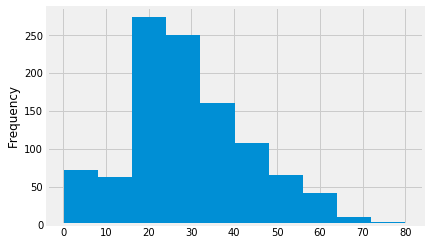

In [22]:
df.continuous.age.plot.hist();

In [23]:
normaltest(df.continuous.age, nan_policy='omit')

NormaltestResult(statistic=28.167942011008588, pvalue=7.645556622690597e-07)

In [24]:
skewtest(df.continuous.age, nan_policy='omit')

SkewtestResult(statistic=5.214437531634691, pvalue=1.8437582114885934e-07)

In [25]:
kurtosistest(df.continuous.age, nan_policy='omit')

KurtosistestResult(statistic=0.9887280918878047, pvalue=0.32279619456686603)

In [26]:
df.continuous.age.kurtosis()

0.1469476357378139

- The historgram for `age` doesn't really look normal.
- Testing for normality returns a low p-value, rejecting the null-hypothesis that the data is normally distributed (there's enough evidence to say it's not).
- Testing skewness also returns a low p-value and a skewness of 0.4 (positively skewed).
- Test kurtosis returns high p-value and a kurtosis of 0.15.

Let's see if we can transform the data with a box-cox transformation.

In [27]:
from scipy.stats import boxcox, boxcox_normplot

In [28]:
boxcox_age, max_log = boxcox(df.continuous.age.dropna())

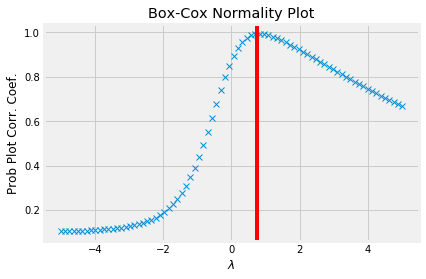

In [29]:
fig, ax = plt.subplots()
bc_plot = boxcox_normplot(df.continuous.age.dropna(), -5, 5, plot=ax)
ax.axvline(max_log, c='r');

In [30]:
skewtest(boxcox_age)

SkewtestResult(statistic=-0.4870998583656714, pvalue=0.6261875667865451)

In [31]:
kurtosistest(boxcox_age)

KurtosistestResult(statistic=1.2825828877607321, pvalue=0.1996382485217043)

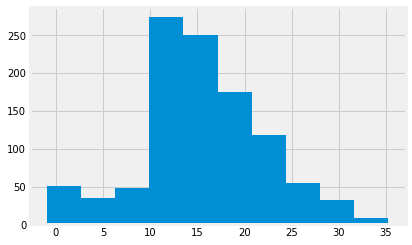

In [32]:
plt.hist(boxcox_age);

The boxcox transformation returns negative values, which isn't possible for `age`. Let's try a sqare-root transformation.

In [33]:
sqrt_age = np.sqrt(df.continuous.age.dropna())

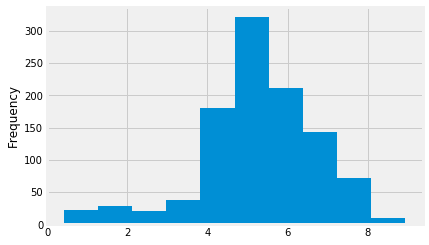

In [34]:
sqrt_age.plot.hist();

In [35]:
normaltest(sqrt_age)

NormaltestResult(statistic=87.75817938582058, pvalue=8.781192047775124e-20)

In [36]:
skewtest(sqrt_age)

SkewtestResult(statistic=-8.035203983780125, pvalue=9.342334707733286e-16)

In [37]:
kurtosistest(sqrt_age)

KurtosistestResult(statistic=4.815981345983869, pvalue=1.4647820797291446e-06)

The sqare-root transformation didn't pass any of the normality tests (normality, skew, kurtosis). Let's try a logarithmic transformation.

In [38]:
log_age = np.log(df.continuous.age.dropna())

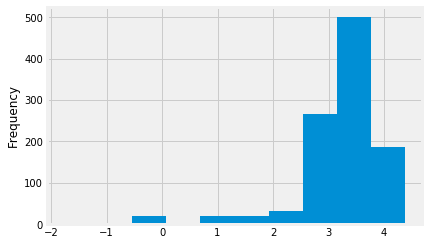

In [39]:
log_age.plot.hist();

In [40]:
normaltest(log_age)

NormaltestResult(statistic=581.4886925238466, pvalue=5.3868486523253154e-127)

In [41]:
skewtest(log_age)

SkewtestResult(statistic=-20.147560406380542, pvalue=2.827067965203307e-90)

In [42]:
kurtosistest(log_age)

KurtosistestResult(statistic=13.250075554316425, pvalue=4.507492536858734e-40)

None of the tests passed and negative values were returned for the log transformation. Let's stick with the original data and see if it's homoscedastic with respect to our columns.

Because the data isn't necessarily normal, we will use the Levene test because it is less sensitive to departures from normality.

In [43]:
from scipy.stats import levene

In [44]:
point_biserial_df = df.loc[:, list(itertools.product(['categorical'], df.categorical.drop(columns=[
    'survived',
    'sibsp',
    'parch'
]).columns))].join(df.loc[:, ('continuous', 'age')]).dropna()

point_biserial_df.columns = point_biserial_df.columns.droplevel()

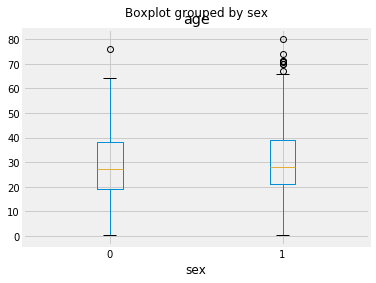

In [45]:
point_biserial_df.boxplot(column = 'age', by = 'sex');

In [46]:
levene(point_biserial_df.loc[
    point_biserial_df.sex == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.sex == 1,
    'age'
])

LeveneResult(statistic=0.749517171340845, pvalue=0.38682804247347446)

Grouping on `sex`, `age` IS homoscedastic.

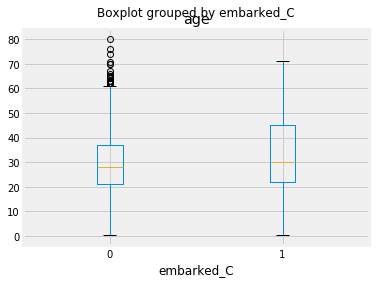

In [47]:
point_biserial_df.boxplot(column = 'age', by = 'embarked_C');

In [48]:
levene(point_biserial_df.loc[
    point_biserial_df.embarked_C == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.embarked_C == 1,
    'age'
])

LeveneResult(statistic=4.7073592930960855, pvalue=0.03025876655611869)

Grouping on `embarked_C`, `age` is NOT homoscedastic (barely, p-value = 0.03 < 0.05)

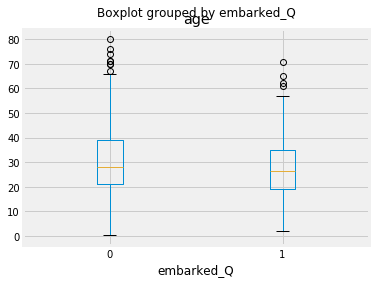

In [49]:
point_biserial_df.boxplot(column='age', by='embarked_Q');

In [50]:
levene(point_biserial_df.loc[
    point_biserial_df.embarked_Q == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.embarked_Q == 1,
    'age'
])

LeveneResult(statistic=0.002564650132088515, pvalue=0.9596201830369783)

Grouping on `embarked_Q`, `age` IS homoscedastic.

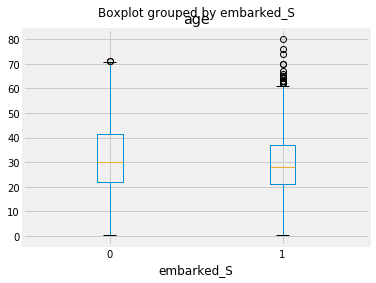

In [51]:
point_biserial_df.boxplot(column='age', by='embarked_S');

In [52]:
levene(point_biserial_df.loc[
    point_biserial_df.embarked_S == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.embarked_S == 1,
    'age'
])

LeveneResult(statistic=4.804293685596284, pvalue=0.02860916051188422)

Grouping on `embarked_S`, `age` is NOT homoscedastic (barely, p-value = 0.03 < 0.05).

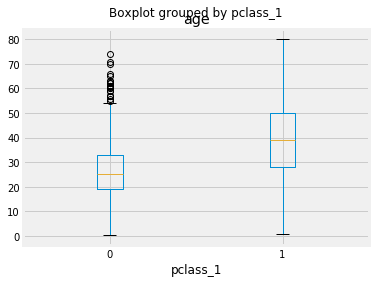

In [53]:
point_biserial_df.boxplot(column='age', by='pclass_1');

In [54]:
levene(point_biserial_df.loc[
    point_biserial_df.pclass_1 == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.pclass_1 == 1,
    'age'
])

LeveneResult(statistic=17.68528415781623, pvalue=2.8299208714720455e-05)

Grouping on `pclass_1`, `age` is NOT homoscedastic.

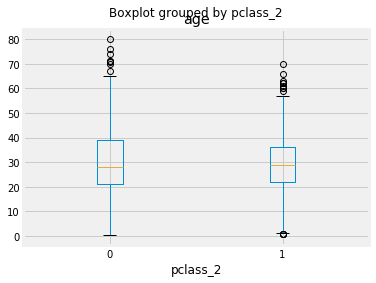

In [55]:
point_biserial_df.boxplot(column='age', by='pclass_2');

In [56]:
levene(point_biserial_df.loc[
    point_biserial_df.pclass_2 == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.pclass_2 == 1,
    'age'
])

LeveneResult(statistic=3.5053868029067923, pvalue=0.06144893098567997)

Grouping on `pclass_2`, `age` IS homoscedastic.

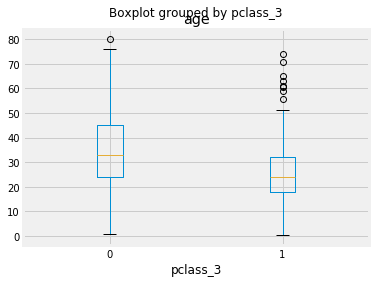

In [57]:
point_biserial_df.boxplot(column='age', by='pclass_3');

In [58]:
levene(point_biserial_df.loc[
    point_biserial_df.pclass_3 == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.pclass_3 == 1,
    'age'
])

LeveneResult(statistic=33.17595159624122, pvalue=1.1067292842455217e-08)

Grouping on `pclass_3`, `age` is NOT homoscedastic.

---

After these results, I think we can compare `age` with the following columns:
- `sex`
- `embarked_C`
- `embarked_Q`
- `embarked_S`
- `pclass_2`

In [59]:
from scipy.stats import pointbiserialr

In [60]:
pb = pd.DataFrame(index=[
    'sex',
    'embarked_C',
    'embarked_Q',
    'embarked_S',
    'pclass_2'
], columns=[
    'correlation',
    'p_value'
])

for i in pb.index:
    pb.loc[
        i,
        'correlation'
    ], pb.loc[
        i,
        'p_value'
    ] = pointbiserialr(point_biserial_df.loc[:, i], point_biserial_df.age)

pb

,correlation,p_value
sex,0.0636449,0.0395877
embarked_C,0.0857773,0.00550316
embarked_Q,-0.019458,0.5296
embarked_S,-0.0759716,0.0139837
pclass_2,-0.0149864,0.628289


It appears that all of the columns chosen to compare with `age` don't really have any correlation.

Let's try a different test and see how it compares with the Point Biserial Correlation.

# Logistic Regression

In [61]:
from statsmodels.api import Logit

We'll use the same data from the Point Biserial data frame.

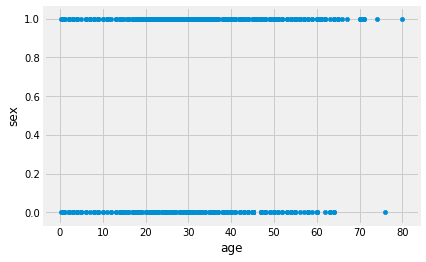

In [62]:
point_biserial_df.plot.scatter('age', 'sex');

In [63]:
logit_model = Logit(endog=point_biserial_df.sex, exog=point_biserial_df.age)

results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.658845
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sex   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:               0.0009214
Time:                        12:04:22   Log-Likelihood:                -689.15
converged:                       True   LL-Null:                       -689.79
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0163      0.002      8.212      0.000       0.012       0.020
==============================================================================
"""

Using logistic regression, `age` has little explanatory power in predicting `sex`.

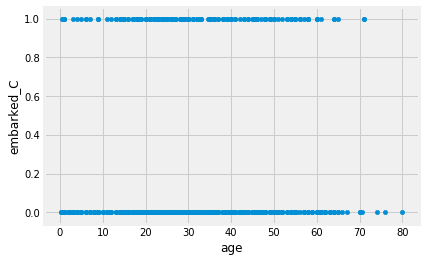

In [64]:
point_biserial_df.plot.scatter('age', 'embarked_C');

In [65]:
logit_model = Logit(endog=point_biserial_df.embarked_C, exog=point_biserial_df.age)

results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 5


C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             embarked_C   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:                     inf
Time:                        12:04:22   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0364      0.002    -15.014      0.000      -0.041      -0.032
==============================================================================
"""

The algorithm did not converge when comparing `age` with `embarked_C`.

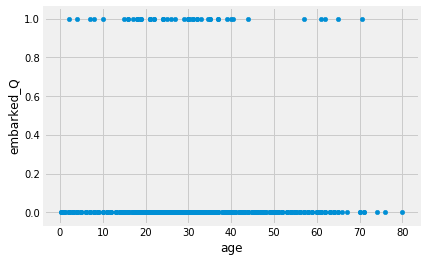

In [66]:
point_biserial_df.plot.scatter('age', 'embarked_Q');

In [67]:
logit_model = Logit(endog=point_biserial_df.embarked_Q, exog=point_biserial_df.age)

results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             embarked_Q   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:                     inf
Time:                        12:04:23   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.1027      0.006    -18.095      0.000      -0.114      -0.092
==============================================================================
"""

The algorithm did not converge when comparing `age` with `embarked_Q`.

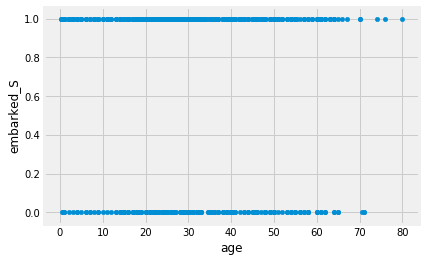

In [68]:
point_biserial_df.plot.scatter('age', 'embarked_S');

In [69]:
logit_model = Logit(endog=point_biserial_df.embarked_S, exog=point_biserial_df.age)

results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.283566
         Iterations 5


C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             embarked_S   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:                     inf
Time:                        12:04:23   Log-Likelihood:                -296.61
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0282      0.002     12.766      0.000       0.024       0.033
==============================================================================
"""

The algorithm did not converge when comparing `age` with `embarked_S`.

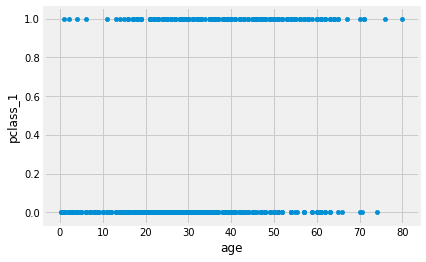

In [70]:
point_biserial_df.plot.scatter('age', 'pclass_1');

In [71]:
logit_model = Logit(endog=point_biserial_df.pclass_1, exog=point_biserial_df.age)

results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 80.462682
         Iterations 4


C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pclass_1   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:                     inf
Time:                        12:04:24   Log-Likelihood:                -84164.
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0163      0.002     -8.228      0.000      -0.020      -0.012
==============================================================================
"""

The algorithm did not converge when comparing `age` with `pclass_1`.

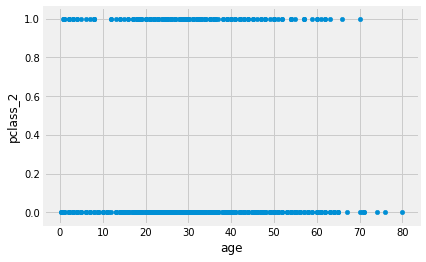

In [72]:
point_biserial_df.plot.scatter('age', 'pclass_2');

In [73]:
logit_model = Logit(endog=point_biserial_df.pclass_2, exog=point_biserial_df.age)

results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 182.490245
         Iterations 5


C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pclass_2   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:                     inf
Time:                        12:04:24   Log-Likelihood:            -1.9088e+05
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0317      0.002    -13.804      0.000      -0.036      -0.027
==============================================================================
"""

The algorithm did not converge when comparing `age` with `pclass_2`.

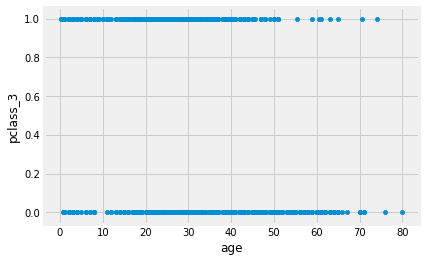

In [74]:
point_biserial_df.plot.scatter('age', 'pclass_3');

In [75]:
logit_model = Logit(endog=point_biserial_df.pclass_3, exog=point_biserial_df.age)

results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 52.421118
         Iterations 4


C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pclass_3   No. Observations:                 1046
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Feb 2019   Pseudo R-squ.:                     inf
Time:                        12:04:24   Log-Likelihood:                -54832.
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0113      0.002     -5.895      0.000      -0.015      -0.008
==============================================================================
"""

The algorithm did not converge when comparing `age` with `pclass_3`.

---

Logistic Regression agreed with the Point Biserial Correlation when comparing `age` with `sex`, but could not give an accurate description with the other variables. Let's try using the Kruskal-Wallis H Test.

# Kruskal-Wallis H Test

The Kruskal-Wallis H test can only tell us if two or more population medians are different. It does not tell us the strength of the relationship or even if there is one.

In [76]:
from scipy.stats import kruskal

In [77]:
point_biserial_df.groupby('sex').age.median()

sex
0    27.0
1    28.0
Name: age, dtype: float64

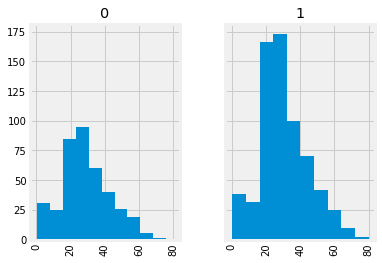

In [78]:
point_biserial_df.hist(column='age', by='sex', sharex=True, sharey=True);

In [79]:
kruskal(point_biserial_df.loc[
    point_biserial_df.sex == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.sex == 1,
    'age'
])

KruskalResult(statistic=4.151628793971187, pvalue=0.041594495158714544)

Grouping on `sex`, the medians for `age` are barely different (p-value = 0.04 < 0.05).

In [80]:
point_biserial_df.groupby('embarked_C').age.median()

embarked_C
0    28.0
1    30.0
Name: age, dtype: float64

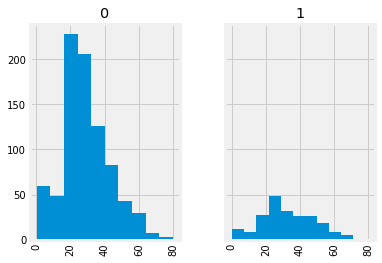

In [81]:
point_biserial_df.hist(column='age', by='embarked_C', sharex=True, sharey=True);

In [82]:
kruskal(point_biserial_df.loc[
    point_biserial_df.embarked_C == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.embarked_C == 1,
    'age'
])

KruskalResult(statistic=7.090890427468188, pvalue=0.007747674362405233)

Grouping on `embarked_C`, the medians for `age` are different.

In [83]:
point_biserial_df.groupby('embarked_Q').age.median()

embarked_Q
0    28.0
1    26.5
Name: age, dtype: float64

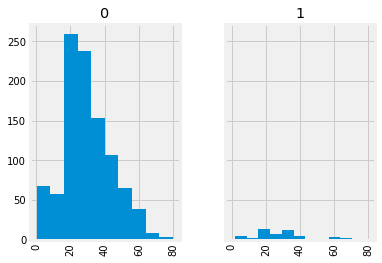

In [84]:
point_biserial_df.hist(column='age', by='embarked_Q', sharex=True, sharey=True);

In [85]:
kruskal(point_biserial_df.loc[
    point_biserial_df.embarked_Q == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.embarked_Q == 1,
    'age'
])

KruskalResult(statistic=0.9042153677433654, pvalue=0.34165392513753284)

Grouping on `embarked_Q`, the medians for `age` are not different.

In [86]:
point_biserial_df.groupby('embarked_S').age.median()

embarked_S
0    30.0
1    28.0
Name: age, dtype: float64

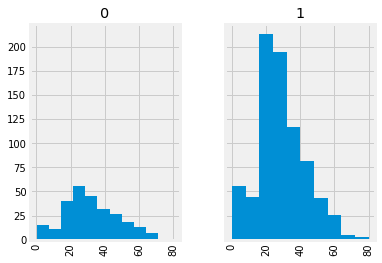

In [87]:
point_biserial_df.hist(column='age', by='embarked_S', sharex=True, sharey=True);

In [88]:
kruskal(point_biserial_df.loc[
    point_biserial_df.embarked_S == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.embarked_S == 1,
    'age'
])

KruskalResult(statistic=4.724977243252208, pvalue=0.02972757667641714)

Grouping on `embarked_S`, the medians for `age` are barely different (p-value = 0.03 < 0.05).

In [89]:
point_biserial_df.groupby('pclass_1').age.median()

pclass_1
0    25.0
1    39.0
Name: age, dtype: float64

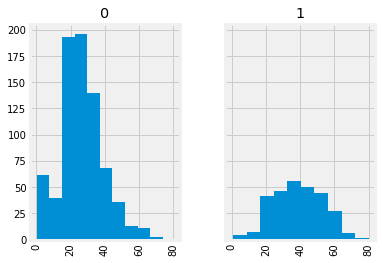

In [90]:
point_biserial_df.hist(column='age', by='pclass_1', sharex=True, sharey=True);

In [91]:
kruskal(point_biserial_df.loc[
    point_biserial_df.pclass_1 == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.pclass_1 == 1,
    'age'
])

KruskalResult(statistic=148.92361266859652, pvalue=2.980148188800045e-34)

Grouping on `pclass_1`, the medians for `age` are different.

In [92]:
point_biserial_df.groupby('pclass_2').age.median()

pclass_2
0    28.0
1    29.0
Name: age, dtype: float64

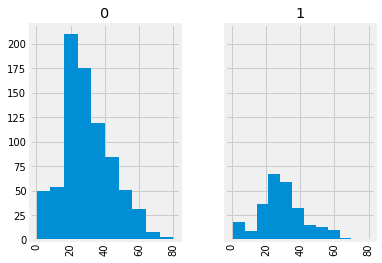

In [93]:
point_biserial_df.hist(column='age', by='pclass_2', sharex=True, sharey=True);

In [94]:
kruskal(point_biserial_df.loc[
    point_biserial_df.pclass_2 == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.pclass_2 == 1,
    'age'
])

KruskalResult(statistic=0.024015161368676017, pvalue=0.8768463404353709)

Grouping on `pclass_2`, the medians for `age` are not different.

In [95]:
point_biserial_df.groupby('pclass_3').age.median()

pclass_3
0    33.0
1    24.0
Name: age, dtype: float64

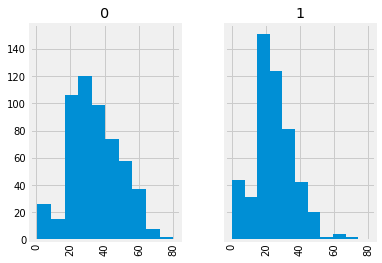

In [96]:
point_biserial_df.hist(column='age', by='pclass_3', sharex=True, sharey=True);

In [97]:
kruskal(point_biserial_df.loc[
    point_biserial_df.pclass_3 == 0,
    'age'
], point_biserial_df.loc[
    point_biserial_df.pclass_3 == 1,
    'age'
])

KruskalResult(statistic=120.96763924326049, pvalue=3.884163648953607e-28)

Grouping on `pclass_3`, the medians for `age` are different.

---

There are clearly differences in `age` when splitting on some of the dichotomous variables, but no strong explanatory power.

Let's see if we can accurately predict some of our ages using these variables.

In [98]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import model_selection

regressors = {
    'LinearRegression' : LinearRegression(),
    'Lasso' : Lasso(),
    'ElasticNet' : ElasticNet(),
    'Ridge' : Ridge(),
    'SVR_linear' : SVR(kernel='linear'),
    'SVR_rbf' : SVR(kernel='rbf', gamma='auto'),
    'AdaBoostRegressor' : AdaBoostRegressor(),
    'BaggingRegressor' : BaggingRegressor(),
    'ExtraTreesRegressor' : ExtraTreesRegressor(n_estimators=100),
    'GradientBoostingRegressor' : GradientBoostingRegressor(),
    'RandomForestRegressor' : RandomForestRegressor(n_estimators=100)
}

regressor_df = pd.DataFrame(index=regressors.keys(), columns = [
    'accuracy',
    'std'
])

In [99]:
age_df = df.loc[df.continuous.age.isnull() == False, :'continuous']

age_df.columns = age_df.columns.droplevel(level=0)

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')
age_y = age_df.age

scaled_age_X = preprocessing.scale(age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':


In [100]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.303964,0.0875172
SVR_rbf,0.225153,0.0535525
Ridge,0.214517,0.0720416
LinearRegression,0.213145,0.0717815
AdaBoostRegressor,0.209086,0.10447
SVR_linear,0.206102,0.0708444
Lasso,0.200956,0.0658801
ElasticNet,0.191156,0.050369
RandomForestRegressor,0.18873,0.125123
BaggingRegressor,0.1696,0.126634


Gradient Boosting did remarkably well versus the other algorithms I tried. But I want over 50%. Let's build some features and see if we can get any better.

In [101]:
df.other.isnull().any()

name      False
ticket    False
cabin      True
dtype: bool

Of the `other` columns, `cabin` has null values. I'll disregard it for now.

Let's start by looking at `name`.

In [102]:
s = pd.Series(''.join(df.other.name.str.lower().str.replace('[^\w\s]', '')).split()).value_counts()

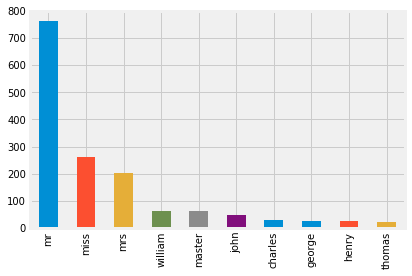

In [103]:
s.iloc[:10].plot.bar();

`name` looks like it can be split into `title`, `last_name`, and `other`.

In [104]:
df[('other', 'last_name')] = df.other.name.str.split(',', expand=True)[0]

In [105]:
df[('other', 'title')] = df.other.name.str.split(',', expand=True)[1].str.strip().str.split('.', expand=True)[0]

In [106]:
df[('other', 'fm_name')] = df.other.name.str.split(',', expand=True)[1].str.strip().str.split('.', expand=True).loc[:, 1:].fillna('').sum(axis=1).str.strip()

In [107]:
df.head()

categorical                                                            \
           survived sex sibsp parch embarked_C embarked_Q embarked_S pclass_1   
train 0         0.0   1     1     0          0          0          1        0   
      1         1.0   0     1     0          1          0          0        1   
      2         1.0   0     0     0          0          0          1        0   
      3         1.0   0     1     0          0          0          1        1   
      4         0.0   1     0     0          0          0          1        0   

                          continuous           \
        pclass_2 pclass_3        age     fare   
train 0        0        1       22.0   7.2500   
      1        0        0       38.0  71.2833   
      2        0        1       26.0   7.9250   
      3        0        0       35.0  53.1000   
      4        0        1       35.0   8.0500   

                                                     other                    \
                                                      name            ticket   
train 0                            Braund, Mr. Owen Harris         A/5 21171   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...          PC 17599   
      2                             Heikkinen, Miss. Laina  STON/O2. 3101282   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)            113803   
      4                           Allen, Mr. William Henry            373450   

                                                                       
        cabin  last_name title                                fm_name  
train 0   NaN     Braund    Mr                            Owen Harris  
      1   C85    Cumings   Mrs  John Bradley (Florence Briggs Thayer)  
      2   NaN  Heikkinen  Miss                                  Laina  
      3  C123   Futrelle   Mrs          Jacques Heath (Lily May Peel)  
      4   NaN      Allen    Mr                          William Henry

Let's take a look at our `title` column.

In [108]:
df.other.title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Sir               1
Dona              1
Lady              1
Capt              1
Jonkheer          1
Mme               1
the Countess      1
Don               1
Name: title, dtype: int64

We've got quite a few values. I don't want to encode them all because I don't want the algorithm to be biased over the size of the number. Instead, I'll make dummy variables.

In [109]:
titles = pd.get_dummies(df.other.title)

# Low Variance Filter

Before continuing I want to remove some titles that don't supply much information, i.e. they have very low variance. Low variance suggests that not much changes whether the value is present or not.

In [110]:
titles = titles.loc[:, titles.columns[titles.var() >= 0.01]].copy()

In [111]:
titles.columns = pd.MultiIndex.from_product([
    ['categorical'],
    titles.columns
])

In [112]:
df = df.join(titles).sort_index(axis=1)

Let's see if any of these correlate with `age`.

In [113]:
df.corrwith(df.continuous.age).abs().sort_values()

categorical  pclass_2      0.014986
             embarked_Q    0.019458
             sex           0.063645
             embarked_S    0.075972
             survived      0.077221
             embarked_C    0.085777
             parch         0.150917
continuous   fare          0.178740
categorical  Mr            0.183965
             Mrs           0.217502
             sibsp         0.243699
             Miss          0.282033
             pclass_3      0.337069
             Master        0.391259
             pclass_1      0.393198
continuous   age           1.000000
dtype: float64

Looks like we have a few contenders. Let's see if any have significant importance.

In [115]:
age_df = df.drop(columns='other')

age_df.columns = age_df.columns.droplevel()

age_df = age_df.loc[age_df.age.isnull() == False].copy()

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')

age_y = age_df.age

scaled_age_X = preprocessing.scale(age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app


In [116]:
importance_df = pd.DataFrame(index=regressors.keys(), columns=pd.MultiIndex.from_product((age_X.columns, [
    'importance',
    'std'
])))

for k,v in regressors.items():
    fit = v.fit(scaled_age_X, age_y)
    try:
        importances = fit.feature_importances_
        std = np.std([tree.feature_importances_ for tree in fit.estimators_], axis = 0)
        importance_df.loc[k, (slice(None), 'importance')] = importances
        importance_df.loc[k, (slice(None), 'std')] = std
    except AttributeError as e:
        importance_df.loc[k, (slice(None), 'importance')] = None
        importance_df.loc[k, (slice(None), 'std')] = None

importance_df = importance_df.stack(1)

importance_df

Master         Miss          Mr  \
AdaBoostRegressor     importance     0.249363     0.242701           0   
                      std            0.104353     0.115411           0   
ExtraTreesRegressor   importance     0.168727     0.132492  0.00874355   
                      std         0.000141824  0.000111368  0.00372797   
RandomForestRegressor importance     0.171308     0.127831   0.0181951   
                      std           0.0355597    0.0194543   0.0107258   

                                         Mrs  embarked_C  embarked_Q  \
AdaBoostRegressor     importance  0.00644652           0   0.0231157   
                      std          0.0160698           0   0.0565963   
ExtraTreesRegressor   importance   0.0111504   0.0139014   0.0140127   
                      std         0.00331766  0.00500264  0.00128987   
RandomForestRegressor importance   0.0119224   0.0181226   0.0105119   
                      std         0.00931716   0.0064365  0.00757582   

                                  embarked_S       fare       parch  \
AdaBoostRegressor     importance           0   0.103489   0.0822944   
                      std                  0   0.154968   0.0836362   
ExtraTreesRegressor   importance   0.0125447   0.267975    0.101682   
                      std         0.00504311  0.0092757  0.00930147   
RandomForestRegressor importance   0.0155577   0.277779    0.100172   
                      std          0.0079798  0.0221113   0.0175421   

                                     pclass_1    pclass_2    pclass_3  \
AdaBoostRegressor     importance     0.196399   0.0187493   0.0770088   
                      std            0.151732   0.0464935     0.12994   
ExtraTreesRegressor   importance      0.19804   0.0106205  0.00966576   
                      std         0.000166464  0.00706821   0.0070834   
RandomForestRegressor importance     0.173522  0.00860834    0.012663   
                      std           0.0403937  0.00776902   0.0197013   

                                         sex        sibsp  
AdaBoostRegressor     importance           0  0.000433566  
                      std                  0  0.000517988  
ExtraTreesRegressor   importance   0.0089729     0.041473  
                      std         0.00434354   0.00824123  
RandomForestRegressor importance   0.0113129    0.0424949  
                      std         0.00545475   0.00941883

In [117]:
t = importance_df.xs('importance', level=1).copy()
t.sort_values(t.columns.tolist(), ascending=False, inplace=True)
t.sort_values(t.index.tolist(), axis=1, ascending=False, inplace=True)
t.sort_values(t.columns.tolist(), ascending=False)

,Master,Miss,pclass_1,fare,parch,pclass_3,embarked_Q,pclass_2,Mrs,sibsp,Mr,embarked_C,embarked_S,sex
AdaBoostRegressor,0.249363,0.242701,0.196399,0.103489,0.0822944,0.0770088,0.0231157,0.0187493,0.00644652,0.000433566,0,0,0,0
RandomForestRegressor,0.171308,0.127831,0.173522,0.277779,0.100172,0.012663,0.0105119,0.00860834,0.0119224,0.0424949,0.0181951,0.0181226,0.0155577,0.0113129
ExtraTreesRegressor,0.168727,0.132492,0.19804,0.267975,0.101682,0.00966576,0.0140127,0.0106205,0.0111504,0.041473,0.00874355,0.0139014,0.0125447,0.0089729


In [118]:
t.loc['RandomForestRegressor'].sort_values(ascending=False).head()

fare        0.277779
pclass_1    0.173522
Master      0.171308
Miss        0.127831
parch       0.100172
Name: RandomForestRegressor, dtype: object

In [119]:
t.loc['ExtraTreesRegressor'].sort_values(ascending=False).head()

fare        0.267975
pclass_1     0.19804
Master      0.168727
Miss        0.132492
parch       0.101682
Name: ExtraTreesRegressor, dtype: object

In [120]:
t.loc['AdaBoostRegressor'].sort_values(ascending=False).head()

Master       0.249363
Miss         0.242701
pclass_1     0.196399
fare         0.103489
parch       0.0822944
Name: AdaBoostRegressor, dtype: object

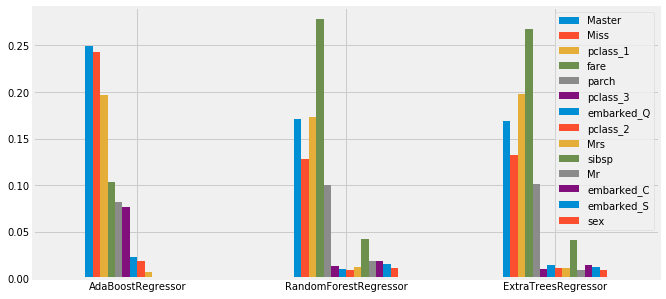

In [121]:
ax = t.plot.bar(figsize=(10,5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

For the 3 algorithms that produced feature importances, all three had 5 features that had importances of about 10% or greater. On top of that, the 5 features from each algorithm are the same.

Let's use all features and see if we can predict age better. Then we can try limiting to the top 5.

In [122]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.456029,0.0665531
Ridge,0.409003,0.0598204
LinearRegression,0.408957,0.0596247
SVR_linear,0.394903,0.0659949
AdaBoostRegressor,0.394372,0.0826628
Lasso,0.378563,0.0693394
RandomForestRegressor,0.376601,0.0906693
SVR_rbf,0.353407,0.0462885
BaggingRegressor,0.35315,0.09598
ElasticNet,0.349797,0.0535776


We got about 50% better accuracy with the Gradient Boosting Regressor leading the way again. Can we get higher by limiting the features to the top 5 most important?

In [123]:
top_five = ['fare', 'pclass_1', 'Master', 'Miss', 'parch']

scaled_age_X = preprocessing.scale(age_X[top_five])

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [124]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.437731,0.0862683
AdaBoostRegressor,0.390593,0.0909471
SVR_rbf,0.379912,0.0751693
Ridge,0.376478,0.094466
LinearRegression,0.376461,0.0945052
Lasso,0.367625,0.0799945
SVR_linear,0.360635,0.0951507
RandomForestRegressor,0.350855,0.133423
BaggingRegressor,0.334055,0.142373
ElasticNet,0.318079,0.0662461


Accuracy dropped a few points for our top performing algorithms, but some also did much better (Linear Regression jumped from nearly 0% to over 37%). Let's try some PCA to combine features and see if we can get better results.

# PCA

In [125]:
from sklearn.decomposition import PCA

# keep 99% explainable variance
pca = PCA(n_components=.99)

age_df = df.drop(columns='other')

age_df.columns = age_df.columns.droplevel()

age_df = age_df.loc[age_df.age.isnull() == False].copy()

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')

age_y = age_df.age

scaled_age_X = preprocessing.scale(age_X)

pca.fit(scaled_age_X)

scaled_age_X = pca.transform(scaled_age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.


In [126]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.420232,0.0539832
Ridge,0.395133,0.0677353
LinearRegression,0.395111,0.067749
SVR_linear,0.385085,0.0714255
Lasso,0.360638,0.0620969
RandomForestRegressor,0.355962,0.0665515
ElasticNet,0.345999,0.0567679
SVR_rbf,0.338086,0.0468868
BaggingRegressor,0.337311,0.084568
AdaBoostRegressor,0.284797,0.102234


Trying to keep 99% of variance with all features results in lower accuracy. Let's try the top 5 again.

In [127]:
top_five = ['fare', 'pclass_1', 'Master', 'Miss', 'parch']

scaled_age_X = preprocessing.scale(age_X[top_five])

pca.fit(scaled_age_X)

scaled_age_X = pca.transform(scaled_age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.416023,0.103516
SVR_rbf,0.379912,0.0751693
AdaBoostRegressor,0.378479,0.0804966
Ridge,0.376478,0.094466
LinearRegression,0.376461,0.0945052
RandomForestRegressor,0.364385,0.139679
SVR_linear,0.360635,0.0951507
Lasso,0.344791,0.0861023
BaggingRegressor,0.340038,0.142526
ElasticNet,0.312598,0.0698711


About the same compared to when using all the features, but still worse than without PCA. Let's try Isomap.

# Isomap

In [129]:
from sklearn.manifold import Isomap

iso = Isomap()

age_df = df.drop(columns='other')

age_df.columns = age_df.columns.droplevel()

age_df = age_df.loc[age_df.age.isnull() == False].copy()

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')

age_y = age_df.age

scaled_age_X = preprocessing.scale(age_X)

iso.fit(scaled_age_X)

scaled_age_X = iso.transform(scaled_age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.


In [130]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.359281,0.051931
RandomForestRegressor,0.307158,0.0672698
BaggingRegressor,0.278786,0.0905456
AdaBoostRegressor,0.23388,0.0527918
ExtraTreesRegressor,0.221408,0.0964234
SVR_rbf,0.164482,0.0681493
Ridge,0.0617533,0.0384723
LinearRegression,0.0617532,0.0384739
ElasticNet,0.0616902,0.0368832
Lasso,0.0616036,0.0367848


Not good. Let's try with the top 5 features again.

In [131]:
top_five = ['fare', 'pclass_1', 'Master', 'Miss', 'parch']

scaled_age_X = preprocessing.scale(age_X[top_five])

iso.fit(scaled_age_X)

scaled_age_X = iso.transform(scaled_age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.226041,0.0719935
RandomForestRegressor,0.217401,0.115397
BaggingRegressor,0.200473,0.130259
ExtraTreesRegressor,0.198271,0.130403
AdaBoostRegressor,0.0628872,0.080326
Lasso,0.0364579,0.0334013
ElasticNet,0.0363021,0.0334592
SVR_rbf,0.0351859,0.0636173
Ridge,0.0322813,0.0371987
LinearRegression,0.0322703,0.0372036


Worse. Let's check for multicollinearity.

Problem! All of the features in our dataset (except `fare`) are binary. So we can't use our typical correlation techniques. Let's try Cramer's V.

# Cramer's V

In [133]:
from dython.nominal import associations

In [134]:
age_df = df.drop(columns='other')

age_df.columns = age_df.columns.droplevel()

age_df = age_df.loc[age_df.age.isnull() == False].copy()

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')

age_X = age_X.loc[:, age_X.var() >= 0.01].copy()

age_y = age_df.age

age_X_cramer = age_X.drop(columns='fare')

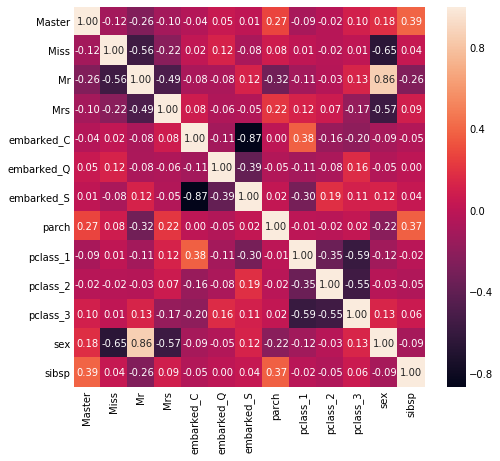

In [135]:
associations(age_X_cramer, figsize = (7,7))

Cramer's V appears to tell us quite a bit. We see strong association between `sex` and `Mr`, and also between `embarked_C` and `embarked_S`. Let's try PCA on these smaller subsets of features.

In [136]:
pca_sex = PCA(n_components=.99)
pca_embarked = PCA(n_components=.99)
pca_pclass = PCA(n_components=.99)

age_df = df.drop(columns='other')

age_df.columns = age_df.columns.droplevel()

age_df = age_df.loc[age_df.age.isnull() == False].copy()

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')

age_X = age_X.loc[:, age_X.var() >= 0.01].copy()

age_y = age_df.age

scaled_age_X_sex = preprocessing.scale(age_X.loc[:, :'Mrs'].join(age_X.sex))

scaled_age_X_embarked = preprocessing.scale(age_X.loc[:, 'embarked_C':'embarked_S'])

scaled_age_X_pclass = preprocessing.scale(age_X.loc[:, 'pclass_1':'pclass_3'])

scaled_age_X_rest = preprocessing.scale(age_X.loc[:, ['parch', 'sibsp', 'fare']])

pca_sex.fit(scaled_age_X_sex)
scaled_age_X_sex = pca_sex.transform(scaled_age_X_sex)

pca_embarked.fit(scaled_age_X_embarked)
scaled_age_X_embarked = pca_embarked.transform(scaled_age_X_embarked)

pca_pclass.fit(scaled_age_X_pclass)
scaled_age_X_pclass = pca_pclass.transform(scaled_age_X_pclass)

scaled_age_X = np.hstack((
    scaled_age_X_embarked,
    scaled_age_X_pclass,
    scaled_age_X_rest,
    scaled_age_X_sex
))

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int8, uint8 were all converted to float64 by the scale function.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.


In [137]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.458314,0.0631988
Ridge,0.406779,0.0641087
LinearRegression,0.406742,0.0640486
SVR_linear,0.389582,0.0683017
RandomForestRegressor,0.385476,0.0922921
AdaBoostRegressor,0.385093,0.0692238
Lasso,0.373316,0.0646542
BaggingRegressor,0.351473,0.102324
ElasticNet,0.350465,0.0556127
SVR_rbf,0.341575,0.047448


Another good increase in accuracy! While not an overall good jump, this showed promise for PCA as it is now comparable with throwing all variables into the algorithms. Let's see if the same can be said for Isomap.

In [138]:
iso_sex = Isomap()
iso_embarked = Isomap()
iso_pclass = Isomap()

age_df = df.drop(columns='other')

age_df.columns = age_df.columns.droplevel()

age_df = age_df.loc[age_df.age.isnull() == False].copy()

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')

age_X = age_X.loc[:, age_X.var() >= 0.01].copy()

age_y = age_df.age

scaled_age_X_sex = preprocessing.scale(age_X.loc[:, :'Mrs'].join(age_X.sex))

scaled_age_X_embarked = preprocessing.scale(age_X.loc[:, 'embarked_C':'embarked_S'])

scaled_age_X_pclass = preprocessing.scale(age_X.loc[:, 'pclass_1':'pclass_3'])

scaled_age_X_rest = preprocessing.scale(age_X.loc[:, ['parch', 'sibsp', 'fare']])

iso_sex.fit(scaled_age_X_sex)
scaled_age_X_sex = iso_sex.transform(scaled_age_X_sex)

iso_embarked.fit(scaled_age_X_embarked)
scaled_age_X_embarked = iso_embarked.transform(scaled_age_X_embarked)

iso_pclass.fit(scaled_age_X_pclass)
scaled_age_X_pclass = iso_pclass.transform(scaled_age_X_pclass)

scaled_age_X = np.hstack((
    scaled_age_X_embarked,
    scaled_age_X_pclass,
    scaled_age_X_rest,
    scaled_age_X_sex
))

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int8, uint8 were all converted to float64 by the scale function.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\kernel_pca.py:299: RuntimeWarning: divide by zero encountered in true_divide
  return np.dot(

The Isomap can't compute due to division by zero in the algorithm. So it's out.

Let's see if we can engineer another feature out of our `other` columns.

# Ticket Holders

In [139]:
ticket_holders = df.groupby(('other', 'ticket'))[[('other', 'name')]].nunique().reset_index().rename(columns={
    'name' : 'ticket_holders'
}, level=1)

ticket_holders.columns = ticket_holders.columns.droplevel()

ticket_holders.columns = pd.MultiIndex.from_arrays([['other', 'categorical'], ticket_holders.columns])

In [140]:
ticket_holders.head()

,other,categorical
,ticket,ticket_holders
0,110152,3
1,110413,3
2,110465,2
3,110469,1
4,110489,1


In [141]:
df = df.reset_index().merge(ticket_holders).set_index(['level_0', 'level_1']).sort_index().sort_index(axis=1)

Let's see if our `ticket_holders` has any association with the other `categorical` features using Cramer's V again.

In [142]:
age_df = df.drop(columns='other')

age_df.columns = age_df.columns.droplevel()

age_df = age_df.loc[age_df.age.isnull() == False].copy()

age_df.drop(columns='survived', inplace=True)

age_df.dropna(inplace=True)

age_X = age_df.drop(columns='age')

age_X = age_X.loc[:, age_X.var() >= 0.01].copy()

age_y = age_df.age

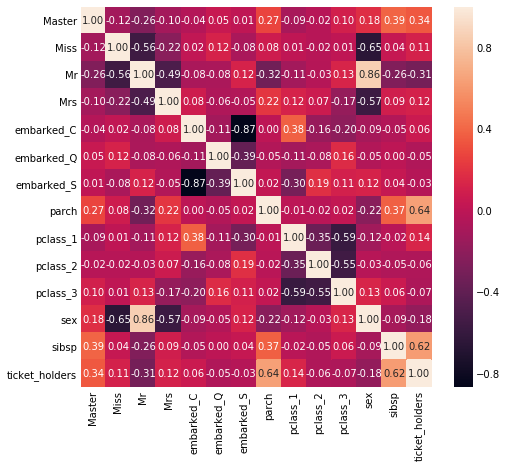

In [143]:
associations(age_X.drop(columns='fare'), figsize = (7,7))

`ticket_holders` has some positive association with `sibsp` and `parch`. Makes sense. Let's see if our algorithm picks up any accuracy by throwing `ticket_holders` in the mix. Then we will try PCA.

In [144]:
scaled_age_X = preprocessing.scale(age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [145]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.4561,0.0673321
Ridge,0.410266,0.0549396
LinearRegression,0.409665,0.054645
SVR_linear,0.395038,0.0667581
Lasso,0.377468,0.0741671
BaggingRegressor,0.375891,0.0848109
AdaBoostRegressor,0.375216,0.0513864
RandomForestRegressor,0.372538,0.0846594
SVR_rbf,0.353827,0.0682559
ElasticNet,0.350845,0.0631839


Some loss in accuracy. Let's try PCA.

In [146]:
pca_sex = PCA(n_components=.99)
pca_embarked = PCA(n_components=.99)
pca_pclass = PCA(n_components=.99)
pca_tix = PCA(n_components=.99)

In [147]:
scaled_age_X_sex = preprocessing.scale(age_X.loc[:, :'Mrs'].join(age_X.sex))

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, uint8 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [148]:
scaled_age_X_embarked = preprocessing.scale(age_X.loc[:, 'embarked_C':'embarked_S'])

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [149]:
scaled_age_X_pclass = preprocessing.scale(age_X.loc[:, 'pclass_1':'pclass_3'])

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [150]:
scaled_age_X_tix = preprocessing.scale(age_X.loc[:, ['ticket_holders', 'sibsp', 'parch']])

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [151]:
scaled_age_X_rest = preprocessing.scale(age_X.loc[:, ['fare']])

In [152]:
pca_sex.fit(scaled_age_X_sex)
scaled_age_X_sex = pca_sex.transform(scaled_age_X_sex)

In [153]:
pca_embarked.fit(scaled_age_X_embarked)
scaled_age_X_embarked = pca_embarked.transform(scaled_age_X_embarked)

In [154]:
pca_pclass.fit(scaled_age_X_pclass)
scaled_age_X_pclass = pca_pclass.transform(scaled_age_X_pclass)

In [155]:
pca_tix.fit(scaled_age_X_tix)
scaled_age_X_tix = pca_tix.transform(scaled_age_X_tix)

In [156]:
scaled_age_X = np.hstack((
    scaled_age_X_embarked,
    scaled_age_X_pclass,
    scaled_age_X_rest,
    scaled_age_X_sex,
    scaled_age_X_tix
))

In [157]:
for k,v in regressors.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    regressor_df.loc[k, 'accuracy'] = results.mean()
    regressor_df.loc[k, 'std'] = results.std()

regressor_df.sort_values([
    'accuracy',
    'std'
], ascending = False)

,accuracy,std
GradientBoostingRegressor,0.44379,0.0577586
Ridge,0.409642,0.0581248
LinearRegression,0.40962,0.0579565
SVR_linear,0.391363,0.0702428
RandomForestRegressor,0.377493,0.0724611
Lasso,0.373002,0.0728458
BaggingRegressor,0.366231,0.0910414
AdaBoostRegressor,0.356619,0.0638536
ElasticNet,0.351158,0.0655626
SVR_rbf,0.342695,0.0687721


A little worse. What if I instead of trying to predict `age` as a continuous variable I tried to discretize `age` into bins? Maybe this will allow my accuracy to go up.

To do this I will try using cumulative plots to find points of extreme change (calculus!)

In [158]:
age_title = age_df.reset_index().melt(id_vars=[
    'level_0',
    'level_1',
    'age'
], value_vars=[
    'Master',
    'Miss',
    'Mr',
    'Mrs'
])

In [159]:
age_title = age_title.groupby([
    'level_0',
    'level_1',
    'age'
])[[
    'value'
]].max().reset_index().merge(age_title)

In [160]:
age_title.loc[age_title.value == 0, 'variable'] = 'other'

In [161]:
age_title.drop_duplicates(inplace=True)

In [162]:
age_title.set_index([
    'level_0',
    'level_1'
], inplace=True)

In [163]:
age_title['age_round'] = age_title.age.round()

In [164]:
age_title1 = age_title.groupby([
    'age_round',
    'variable'
]).agg({
    'value' : 'count'
}).value

In [165]:
age_title2 = age_title1.unstack('variable').fillna(0).cumsum()

In [166]:
age_title1.unstack().loc[:, :'Mrs'].sum()

variable
Master     53.0
Miss      210.0
Mr        580.0
Mrs       170.0
dtype: float64

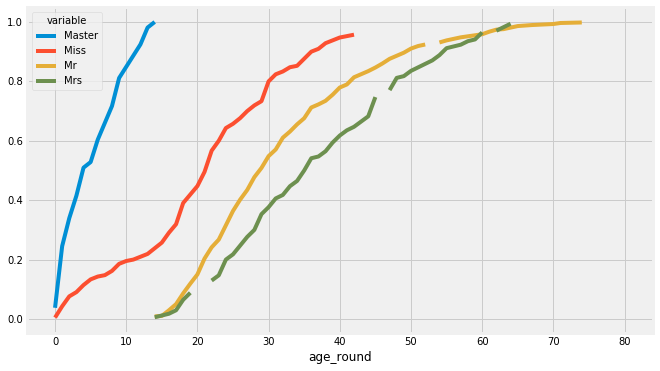

In [167]:
(age_title1.unstack('variable').cumsum().loc[:, :'Mrs'] / age_title1.unstack().loc[:, :'Mrs'].sum()).plot(figsize=(10,6));

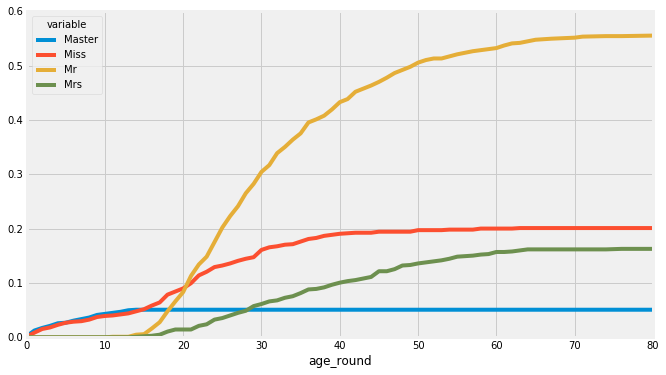

In [168]:
(age_title2.loc[:, :'Mrs'] / age_df.shape[0]).plot(figsize=(10,6))
plt.xlim(0, age_df.age.max())
plt.ylim(0, .6);

In [169]:
age_title_total = age_title.groupby('age_round').value.count().cumsum().to_frame(name='total')

In [170]:
age_title3 = age_title2.loc[:, :'Mrs'].div(age_title_total.total, axis=0)

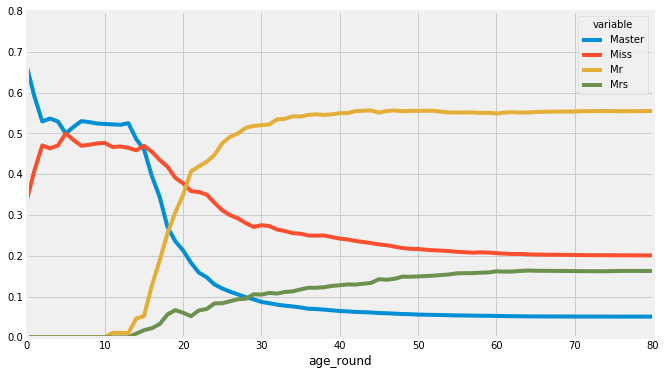

In [171]:
ax = age_title3.plot(figsize=(10,6))
ax.set_xlim(0, age_df.age.max())
ax.set_ylim(0, .8);

This graph shows real potential for seeing when a `title` accounts for more of an `age` group. I could use calculus to determine some cut-points on each line?

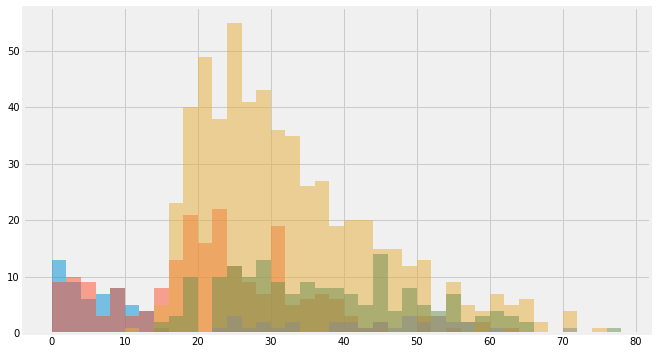

In [172]:
age_title.groupby('variable').age.hist(bins=[i for i in range(0,80,2)], alpha=.5, figsize=(10,6));

#### Entropy Information Gain?

https://www.saedsayad.com/decision_tree.htm

Using `age_title`, I'm going to try and find some cut points for age based on the titles.

In [173]:
age_entropy = age_title.rename(columns={
    'variable' : 'title'
})

In [174]:
age_entropy.head()

age  value title  age_round
level_0 level_1                              
test    0        34.5      1    Mr       34.0
        1        47.0      1   Mrs       47.0
        2        62.0      1    Mr       62.0
        3        27.0      1    Mr       27.0
        4        22.0      1   Mrs       22.0

In [175]:
from scipy.stats import entropy

In [176]:
age_df.head()

Master  Miss  Mr  Mrs  embarked_C  embarked_Q  embarked_S  \
level_0 level_1                                                              
test    0             0     0   1    0           0           1           0   
        1             0     0   0    1           0           0           1   
        2             0     0   1    0           0           1           0   
        3             0     0   1    0           0           0           1   
        4             0     0   0    1           0           0           1   

                 parch  pclass_1  pclass_2  pclass_3  sex  sibsp  \
level_0 level_1                                                    
test    0            0         0         0         1    1      0   
        1            0         0         0         1    0      1   
        2            0         0         1         0    1      0   
        3            0         0         0         1    1      0   
        4            1         0         0         1    0      1   

                 ticket_holders   age     fare  
level_0 level_1                                 
test    0                     1  34.5   7.8292  
        1                     1  47.0   7.0000  
        2                     1  62.0   9.6875  
        3                     1  27.0   8.6625  
        4                     2  22.0  12.2875

In [177]:
entropy_age = age_df.loc[:, [
    'Master',
    'Miss',
    'Mr',
    'Mrs',
    'age'
]].copy()

In [178]:
entropy_age['age_round'] = entropy_age.age.round().astype(int)

In [179]:
entropy_age.head()

Master  Miss  Mr  Mrs   age  age_round
level_0 level_1                                        
test    0             0     0   1    0  34.5         34
        1             0     0   0    1  47.0         47
        2             0     0   1    0  62.0         62
        3             0     0   1    0  27.0         27
        4             0     0   0    1  22.0         22

(age, max info_gain): 14.0, 0.2171778709307564


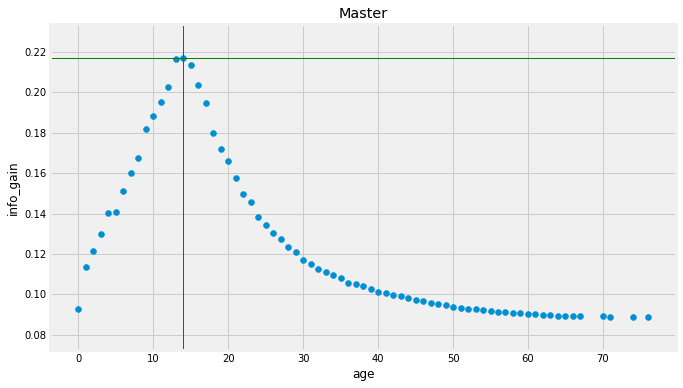

In [180]:
n = 0
info_gain = []
age = []
for i in sorted(age_entropy.age_round.unique()):
    try:
        e = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum() / entropy_age.shape[0], base=2)

        e0 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0].sum())

        p0 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[0]

        e1 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1].sum())

        p1 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Master')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 23.0, 0.25686317944646453


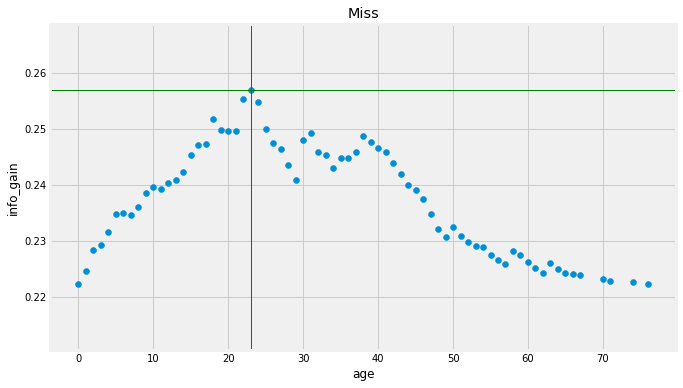

In [181]:
n = 0
info_gain = []
age = []
for i in sorted(age_entropy.age_round.unique()):
    try:
        e = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum() / entropy_age.shape[0], base=2)

        e0 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0].sum())

        p0 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[0]

        e1 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1].sum())

        p1 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Miss')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 13.0, 0.3813424678080406


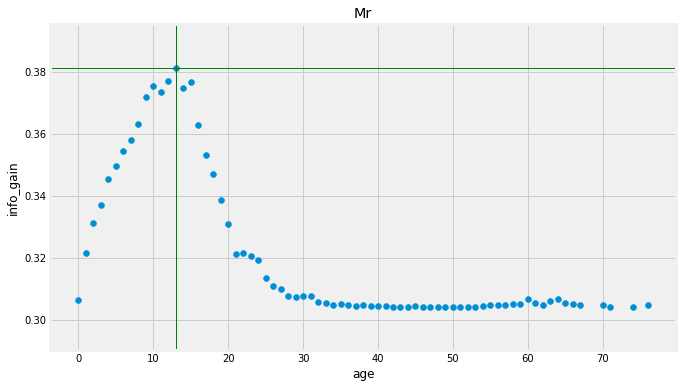

In [182]:
n = 0
info_gain = []
age = []
for i in sorted(age_entropy.age_round.unique()):
    try:
        e = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum() / entropy_age.shape[0], base=2)

        e0 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0].sum())

        p0 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[0]

        e1 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1].sum())

        p1 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mr')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 21.0, 0.21741244970174545


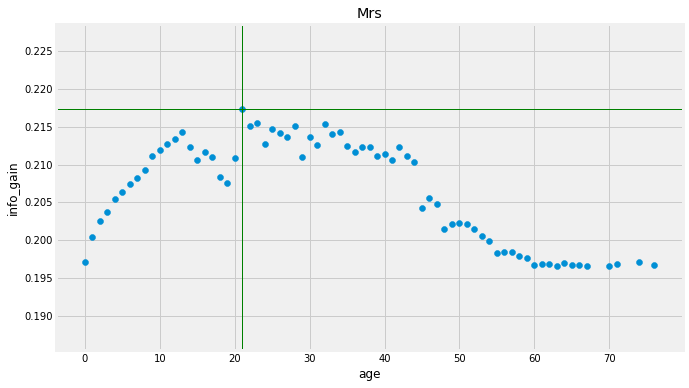

In [183]:
n = 0
info_gain = []
age = []
for i in sorted(age_entropy.age_round.unique()):
    try:
        e = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum() / entropy_age.shape[0], base=2)

        e0 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0].sum())

        p0 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[0]

        e1 = entropy(entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1] / entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1].sum())

        p1 = (entropy_age.groupby([
            entropy_age.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / entropy_age.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mrs')
plt.xlabel('age')
plt.ylabel('info_gain');

The highest information gain was 0.3813424678080406 for Mr. The corresponding age was 13. I will split on this and then test again.

In [184]:
entropy_age['le_13'] = entropy_age.age_round <= 13

In [185]:
le_13 = entropy_age.loc[
    entropy_age.le_13 == True
].copy()

g_13 = entropy_age.loc[
    entropy_age.le_13 == False
].copy()

In [186]:
le_13.head()

Master  Miss  Mr  Mrs   age  age_round  le_13
level_0 level_1                                               
test    21            1     0   0    0   9.0          9   True
        55            1     0   0    0  10.0         10   True
        64            1     0   0    0  13.0         13   True
        80            1     0   0    0   6.0          6   True
        89            1     0   0    0   2.0          2   True

In [187]:
g_13.head()

Master  Miss  Mr  Mrs   age  age_round  le_13
level_0 level_1                                               
test    0             0     0   1    0  34.5         34  False
        1             0     0   0    1  47.0         47  False
        2             0     0   1    0  62.0         62  False
        3             0     0   1    0  27.0         27  False
        4             0     0   0    1  22.0         22  False

##### <= 13

(age, max info_gain): 1, 0.3087712491996345


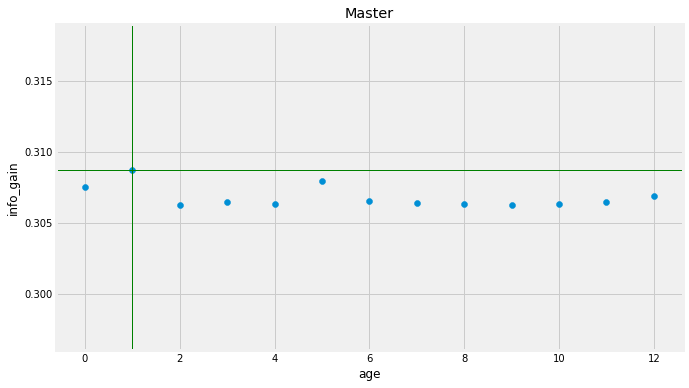

In [188]:
n = 0
info_gain = []
age = []
for i in sorted(le_13.age_round.unique()):
    try:
        e = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum() / le_13.shape[0], base=2)

        e0 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0] / le_13.groupby([
            le_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0].sum())

        p0 = (le_13.groupby([
            le_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[0]

        e1 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1] / le_13.groupby([
            le_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1].sum())

        p1 = (le_13.groupby([
            le_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Master')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 5, 0.30902435853601073


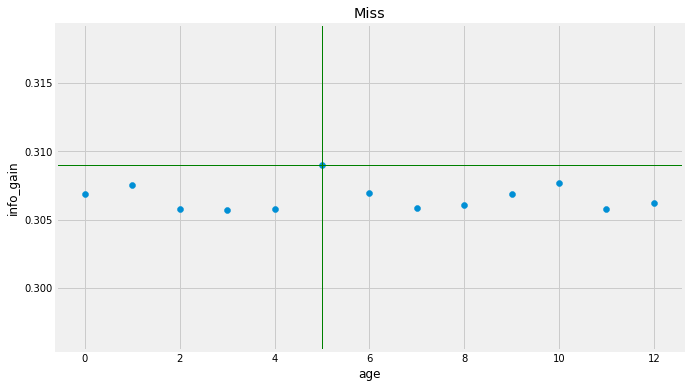

In [189]:
n = 0
info_gain = []
age = []
for i in sorted(le_13.age_round.unique()):
    try:
        e = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum() / le_13.shape[0], base=2)

        e0 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0] / le_13.groupby([
            le_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0].sum())

        p0 = (le_13.groupby([
            le_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[0]

        e1 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1] / le_13.groupby([
            le_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1].sum())

        p1 = (le_13.groupby([
            le_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Miss')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 10, 0.045851301162090574


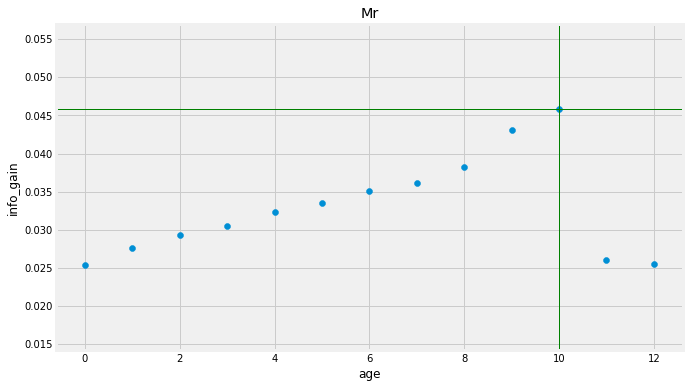

In [190]:
n = 0
info_gain = []
age = []
for i in sorted(le_13.age_round.unique()):
    try:
        e = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum() / le_13.shape[0], base=2)

        e0 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0] / le_13.groupby([
            le_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0].sum())

        p0 = (le_13.groupby([
            le_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[0]

        e1 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1] / le_13.groupby([
            le_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1].sum())

        p1 = (le_13.groupby([
            le_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mr')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 0, 0.0


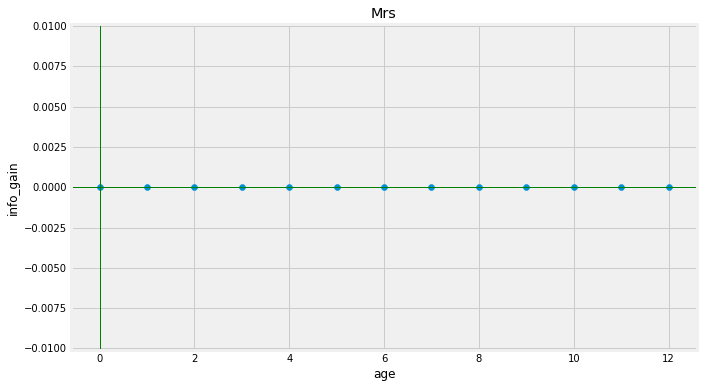

In [191]:
n = 0
info_gain = []
age = []
for i in sorted(le_13.age_round.unique()):
    try:
        e = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum() / le_13.shape[0], base=2)

        e0 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0] / le_13.groupby([
            le_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0].sum())

        p0 = (le_13.groupby([
            le_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[0]

        e1 = entropy(le_13.groupby([
            le_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1] / le_13.groupby([
            le_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1].sum())

        p1 = (le_13.groupby([
            le_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / le_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mrs')
plt.xlabel('age')
plt.ylabel('info_gain');

The highest information gain is 0.30902435853601073 for Miss at age 5. However, the second highest is 0.3087712491996345 for Master at age 1.

I think I will hold off on splitting any further on values <= 13.

##### > 13

(age, max info_gain): 14, 0.008537842375985533


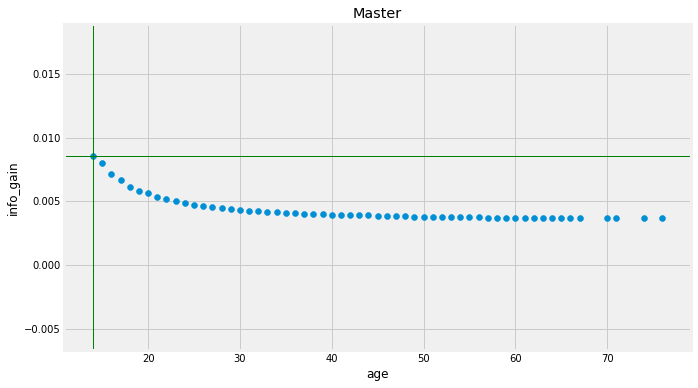

In [192]:
n = 0
info_gain = []
age = []
for i in sorted(g_13.age_round.unique()):
    try:
        e = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum() / g_13.shape[0], base=2)

        e0 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0] / g_13.groupby([
            g_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13.groupby([
            g_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[0]

        e1 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1] / g_13.groupby([
            g_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13.groupby([
            g_13.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Master')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 38, 0.22599841643763002


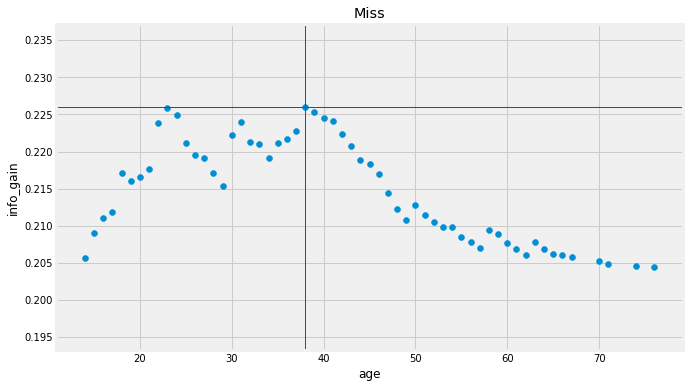

In [193]:
n = 0
info_gain = []
age = []
for i in sorted(g_13.age_round.unique()):
    try:
        e = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum() / g_13.shape[0], base=2)

        e0 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0] / g_13.groupby([
            g_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13.groupby([
            g_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[0]

        e1 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1] / g_13.groupby([
            g_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13.groupby([
            g_13.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Miss')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 15, 0.29879695396482064


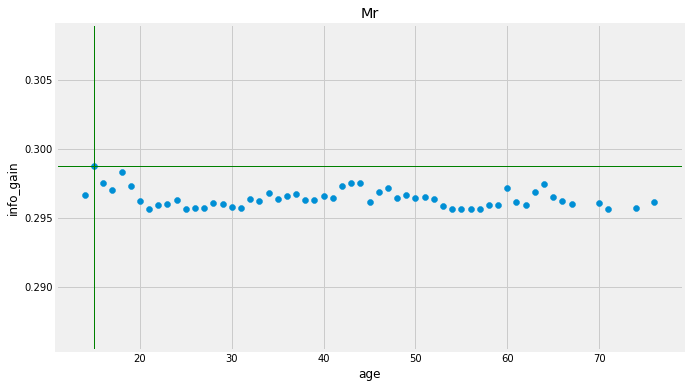

In [194]:
n = 0
info_gain = []
age = []
for i in sorted(g_13.age_round.unique()):
    try:
        e = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum() / g_13.shape[0], base=2)

        e0 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0] / g_13.groupby([
            g_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13.groupby([
            g_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[0]

        e1 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1] / g_13.groupby([
            g_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13.groupby([
            g_13.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mr')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 32, 0.22255122789098347


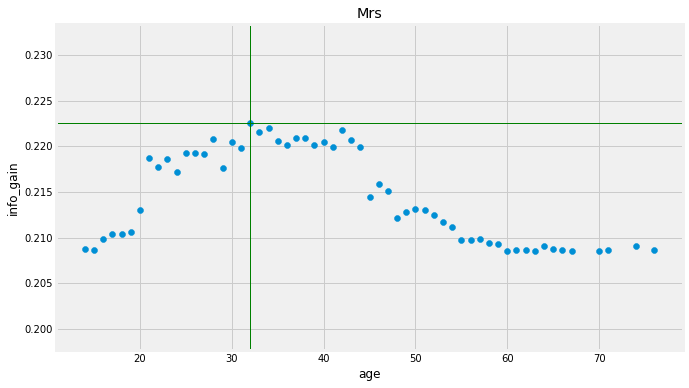

In [195]:
n = 0
info_gain = []
age = []
for i in sorted(g_13.age_round.unique()):
    try:
        e = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum() / g_13.shape[0], base=2)

        e0 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0] / g_13.groupby([
            g_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13.groupby([
            g_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[0]

        e1 = entropy(g_13.groupby([
            g_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1] / g_13.groupby([
            g_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13.groupby([
            g_13.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / g_13.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mrs')
plt.xlabel('age')
plt.ylabel('info_gain');

The highest information gain is 0.29879695396482064 for Mr at age 15. The second highest is 0.22599841643763002 for Miss at age 38. I'll split at 15 and see if we see anything.

In [196]:
g_13['le_15'] = g_13.age_round <= 15

In [197]:
g_13_le_15 = g_13.loc[
    g_13.le_15 == True
].copy()

g_13_g_15 = g_13.loc[
    g_13.le_15 == False
].copy()

In [198]:
g_13_le_15.head()

Master  Miss  Mr  Mrs   age  age_round  le_13  le_15
level_0 level_1                                                      
test    5             0     0   1    0  14.0         14  False   True
        175           0     1   0    0  15.0         15  False   True
        230           0     0   1    0  14.0         14  False   True
        360           1     0   0    0  14.5         14  False   True
train   9             0     0   0    1  14.0         14  False   True

In [199]:
g_13_g_15.head()

Master  Miss  Mr  Mrs   age  age_round  le_13  le_15
level_0 level_1                                                      
test    0             0     0   1    0  34.5         34  False  False
        1             0     0   0    1  47.0         47  False  False
        2             0     0   1    0  62.0         62  False  False
        3             0     0   1    0  27.0         27  False  False
        4             0     0   0    1  22.0         22  False  False

##### 13 < x <= 15

The values in here aren't worth splitting any further as there is only 1 value to split on (14).

##### > 15

(age, max info_gain): 16, 0.0


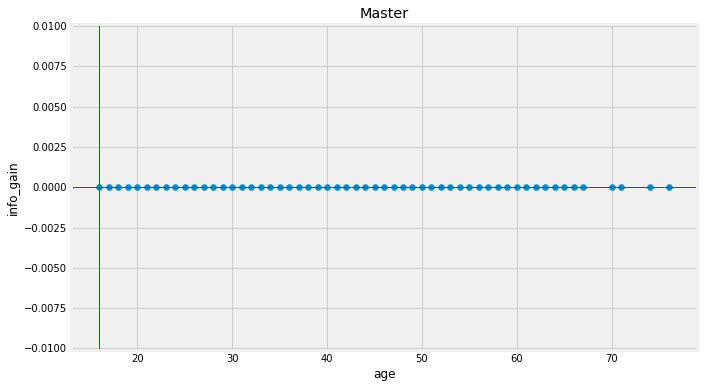

In [200]:
n = 0
info_gain = []
age = []
for i in sorted(g_13_g_15.age_round.unique()):
    try:
        e = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum() / g_13_g_15.shape[0], base=2)

        e0 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Master')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 38, 0.22091771828717727


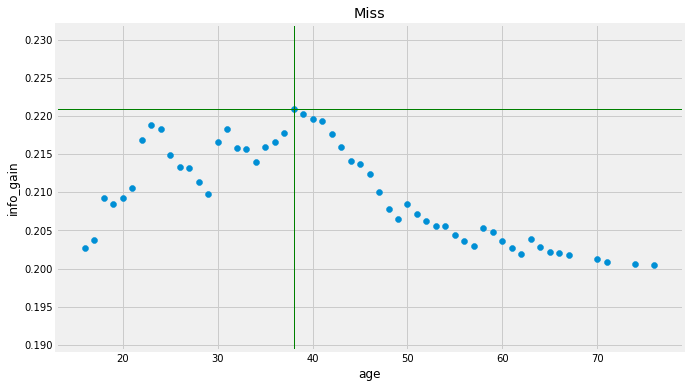

In [201]:
n = 0
info_gain = []
age = []
for i in sorted(g_13_g_15.age_round.unique()):
    try:
        e = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum() / g_13_g_15.shape[0], base=2)

        e0 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Miss')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 44, 0.29685407009765685


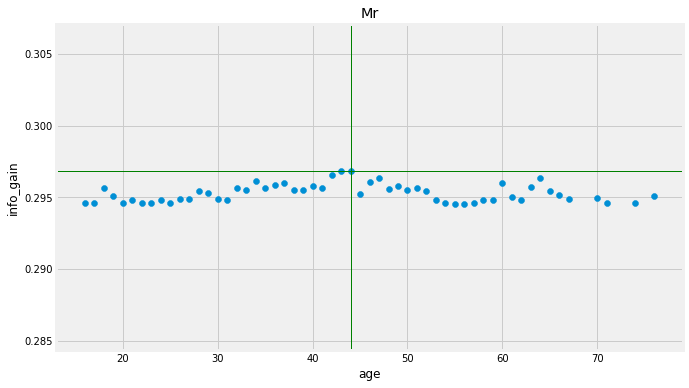

In [202]:
n = 0
info_gain = []
age = []
for i in sorted(g_13_g_15.age_round.unique()):
    try:
        e = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum() / g_13_g_15.shape[0], base=2)

        e0 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mr')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 32, 0.22323039854537174


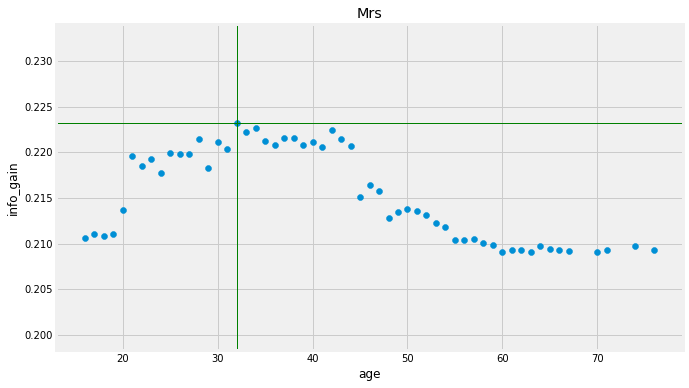

In [203]:
n = 0
info_gain = []
age = []
for i in sorted(g_13_g_15.age_round.unique()):
    try:
        e = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum() / g_13_g_15.shape[0], base=2)

        e0 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1] / g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15.groupby([
            g_13_g_15.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / g_13_g_15.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mrs')
plt.xlabel('age')
plt.ylabel('info_gain');

The highest information gain was 0.29685407009765685 for Mr at age 44. The second highest was 0.22323039854537174 for Mrs at age 32. I choose to split at age 44.

It is worth noting that Master will have no information gain because the highest age for Master is 15.

In [204]:
g_13_g_15['le_44'] = g_13_g_15.age_round <= 44

In [205]:
g_13_g_15_le_44 = g_13_g_15.loc[
    g_13_g_15.le_44 == True
].copy()

g_13_g_15_g_44 = g_13_g_15.loc[
    g_13_g_15.le_44 == False
].copy()

In [206]:
g_13_g_15_g_44.head()

Master  Miss  Mr  Mrs   age  age_round  le_13  le_15  le_44
level_0 level_1                                                             
test    1             0     0   0    1  47.0         47  False  False  False
        2             0     0   1    0  62.0         62  False  False  False
        11            0     0   1    0  46.0         46  False  False  False
        13            0     0   1    0  63.0         63  False  False  False
        14            0     0   0    1  47.0         47  False  False  False

In [207]:
g_13_g_15_le_44.head()

Master  Miss  Mr  Mrs   age  age_round  le_13  le_15  le_44
level_0 level_1                                                             
test    0             0     0   1    0  34.5         34  False  False   True
        3             0     0   1    0  27.0         27  False  False   True
        4             0     0   0    1  22.0         22  False  False   True
        6             0     1   0    0  30.0         30  False  False   True
        7             0     0   1    0  26.0         26  False  False   True

##### 15 < x <= 44

(age, max info_gain): 16, 0.0


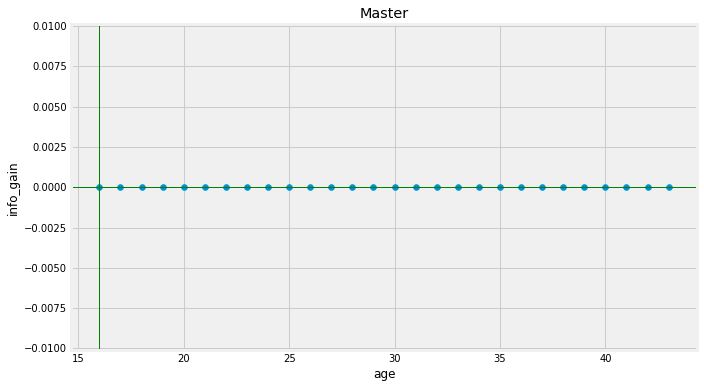

In [208]:
n = 0
info_gain = []
age = []
for i in sorted(g_13_g_15_le_44.age_round.unique()):
    try:
        e = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum() / g_13_g_15_le_44.shape[0], base=2)

        e0 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Master'
        ]).Master.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Master')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 23, 0.23262030956555302


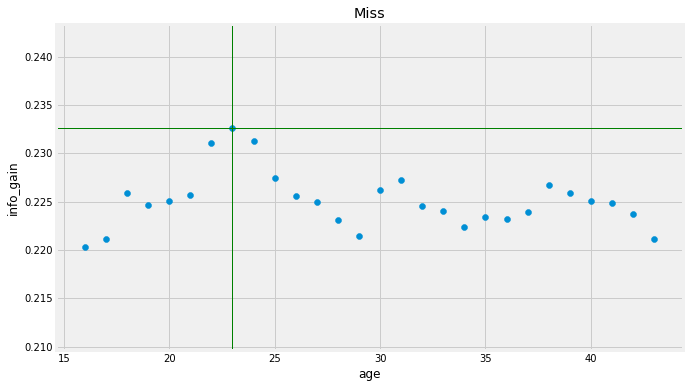

In [209]:
n = 0
info_gain = []
age = []
for i in sorted(g_13_g_15_le_44.age_round.unique()):
    try:
        e = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum() / g_13_g_15_le_44.shape[0], base=2)

        e0 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Miss'
        ]).Miss.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Miss')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 18, 0.2930144045013259


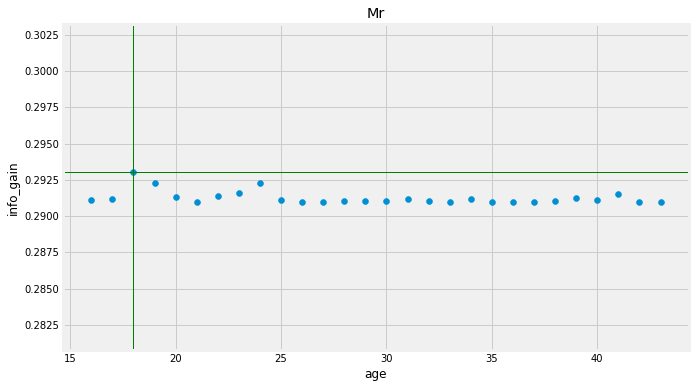

In [210]:
n = 0
info_gain = []
age = []
for i in sorted(g_13_g_15_le_44.age_round.unique()):
    try:
        e = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum() / g_13_g_15_le_44.shape[0], base=2)

        e0 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mr'
        ]).Mr.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mr')
plt.xlabel('age')
plt.ylabel('info_gain');

(age, max info_gain): 21, 0.19578140219649903


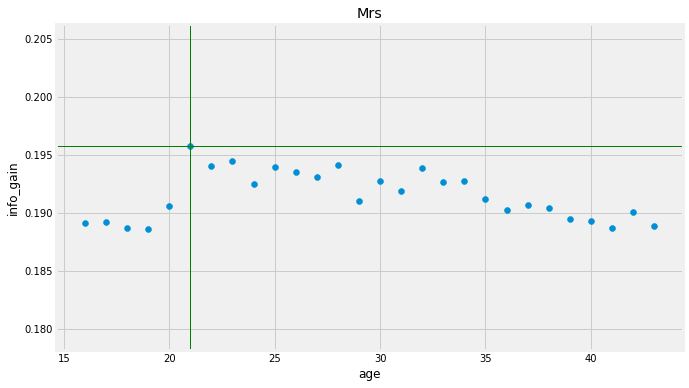

In [211]:
n= 0
info_gain = []
age = []
for i in sorted(g_13_g_15_le_44.age_round.unique()):
    try:
        e = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum() / g_13_g_15_le_44.shape[0], base=2)

        e0 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[0].sum())

        p0 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[0]

        e1 = entropy(g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1] / g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).iloc[1].sum())

        p1 = (g_13_g_15_le_44.groupby([
            g_13_g_15_le_44.age_round <= i,
            'Mrs'
        ]).Mrs.count().unstack().fillna(0).sum(axis=1) / g_13_g_15_le_44.shape[0]).iloc[1]

        eg = p0*e0 + p1*e1

        n = e - eg

        info_gain.append(n)
        age.append(i)
    except IndexError:
        break

print(f"(age, max info_gain): {age[np.argmax(info_gain)]}, {max(info_gain)}")

plt.figure(figsize=(10,6))
plt.scatter(age, info_gain)
plt.axvline(age[np.argmax(info_gain)], c='g', lw=1)
plt.axhline(max(info_gain), c='g', lw=1)
plt.title('Mrs')
plt.xlabel('age')
plt.ylabel('info_gain');

Mr continues to have the highest information gain. I think this is due to the fact that most of the passengers had the title Mr. I'm going to create a column on `age_df` called "age_group" with two values, 0 and 14, where 0 means <= 13 and 14 means > 13.

In [212]:
age_df['age_group'] = age_df.age.apply(lambda x : 13 if x <= 13 else 14)

Now try to predict the age groups using classification algorithms and kfolds.

In [214]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = {
    'MLPClassifier' : MLPClassifier(),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'SVC_linear' : SVC(kernel='linear'),
    'SVC_rbf' : SVC(kernel='rbf', gamma='auto'),
    'GaussianProcessClassifier' : GaussianProcessClassifier(),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100),
    'AdaBoostClassifier' : AdaBoostClassifier(),
    'BaggingClassifier' : BaggingClassifier(),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators=100),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'GaussianNB' : GaussianNB(),
    'QuadraticDiscriminantAnalysis' : QuadraticDiscriminantAnalysis()
}

classifiers_df = pd.DataFrame(index=classifiers.keys(), columns=[
    'accuracy',
    'std'
])

In [215]:
age_X = age_df.drop(columns=[
    'age',
    'age_group'
])
age_y = age_df.age_group

scaled_age_X = preprocessing.scale(age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  import sys


In [216]:
for k,v in classifiers.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    classifiers_df.loc[k, 'accuracy'] = results.mean()
    classifiers_df.loc[k, 'std'] = results.std()

classifiers_df.sort_values([
    'accuracy',
    'std'
], ascending=False)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

,accuracy,std
SVC_rbf,0.984679,0.00877508
RandomForestClassifier,0.983745,0.00745168
ExtraTreesClassifier,0.983745,0.00745168
GradientBoostingClassifier,0.983736,0.00861665
BaggingClassifier,0.982784,0.0102885
DecisionTreeClassifier,0.981822,0.00999539
MLPClassifier,0.98087,0.00953344
GaussianProcessClassifier,0.979908,0.00901447
AdaBoostClassifier,0.978965,0.00827365
KNeighborsClassifier,0.97706,0.0135864


Holy cow! The accuracies for all of the tests are extremely high! The lowest (accuracy, std) is (0.870769, 0.0427326) produced by the GaussianNB algorithm, and the highest (accuracy, std) is (0.984679, 0.00877508) produced by the SVC_rbf algorithm. I'm going to test if the accuracies stay this high when I split age into a 3 groups.

In [217]:
age_df['age_group'] = age_df.age.apply(lambda x : 13 if x <= 13 else (15 if x <= 15 else 16))

In [218]:
age_X = age_df.drop(columns=[
    'age',
    'age_group'
])
age_y = age_df.age_group

scaled_age_X = preprocessing.scale(age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  import sys


In [219]:
for k,v in classifiers.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    classifiers_df.loc[k, 'accuracy'] = results.mean()
    classifiers_df.loc[k, 'std'] = results.std()

classifiers_df.sort_values([
    'accuracy',
    'std'
], ascending=False)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

,accuracy,std
SVC_rbf,0.971291,0.0148141
MLPClassifier,0.968425,0.0142035
GradientBoostingClassifier,0.968416,0.0176616
RandomForestClassifier,0.967473,0.0160702
GaussianProcessClassifier,0.966502,0.0137075
ExtraTreesClassifier,0.964579,0.0196582
KNeighborsClassifier,0.962701,0.0197566
SVC_linear,0.962692,0.016212
BaggingClassifier,0.959826,0.0174846
DecisionTreeClassifier,0.959799,0.019514


The high end didn't change much and only one algorithm (QuadraticDiscriminantAnalysis) dropped significantly. In fact, GaussianNB (originally the lowest) imporved by ~7% and the std stayed about the same (0.04). I'm going to add one more group to age to test the accuracy.

In [220]:
age_df['age_group'] = age_df.age.apply(lambda x : 13 if x <= 13 else (15 if x <= 15 else (44 if x <= 44 else 45)))

In [221]:
age_X = age_df.drop(columns=[
    'age',
    'age_group'
])
age_y = age_df.age_group

scaled_age_X = preprocessing.scale(age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  import sys


In [222]:
for k,v in classifiers.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    classifiers_df.loc[k, 'accuracy'] = results.mean()
    classifiers_df.loc[k, 'std'] = results.std()

classifiers_df.sort_values([
    'accuracy',
    'std'
], ascending=False)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

,accuracy,std
GradientBoostingClassifier,0.805705,0.0274198
SVC_linear,0.79522,0.0200988
MLPClassifier,0.793288,0.0206858
SVC_rbf,0.789441,0.0259187
BaggingClassifier,0.786603,0.0267393
GaussianProcessClassifier,0.783727,0.0177793
RandomForestClassifier,0.78283,0.0248242
ExtraTreesClassifier,0.782821,0.020044
KNeighborsClassifier,0.774194,0.0277497
DecisionTreeClassifier,0.770357,0.0168291


The accuracy plummets if I add the 4th group. To retain the highest accuracy I think I will only separate age into 2 groups, 0 for `age` <= 13 and 1 for `age` > 13

In [223]:
age_df['age_group'] = age_df.age.apply(lambda x : 0 if x <= 13 else 1)

In [224]:
age_X = age_df.drop(columns=[
    'age',
    'age_group'
])
age_y = age_df.age_group

scaled_age_X = preprocessing.scale(age_X)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by the scale function.
  import sys


In [225]:
for k,v in classifiers.items():
    kfold = model_selection.KFold(n_splits=10)
    results = model_selection.cross_val_score(v, scaled_age_X, age_y, cv = kfold)
    classifiers_df.loc[k, 'accuracy'] = results.mean()
    classifiers_df.loc[k, 'std'] = results.std()

classifiers_df.sort_values([
    'accuracy',
    'std'
], ascending=False)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

,accuracy,std
SVC_rbf,0.984679,0.00877508
GradientBoostingClassifier,0.983736,0.00861665
RandomForestClassifier,0.982793,0.00830727
BaggingClassifier,0.982775,0.00939539
MLPClassifier,0.982775,0.00935801
ExtraTreesClassifier,0.981832,0.00996817
DecisionTreeClassifier,0.980861,0.0105002
GaussianProcessClassifier,0.979908,0.00901447
AdaBoostClassifier,0.978965,0.00827365
KNeighborsClassifier,0.97706,0.0135864


Let's figure out which features were most important in determining the `age_group`.

In [226]:
importance_df = pd.DataFrame(index=classifiers_df.keys(), columns=pd.MultiIndex.from_product((age_X.columns, [
    'importance',
    'std'
])))

for k,v in classifiers.items():
    fit = v.fit(scaled_age_X, age_y)
    try:
        importances = fit.feature_importances_
        std = np.std([tree.feature_importances_ for tree in fit.estimators_], axis = 0)
        importance_df.loc[k, (slice(None), 'importance')] = importances
        importance_df.loc[k, (slice(None), 'std')] = std
    except AttributeError as e:
        importance_df.loc[k, (slice(None), 'importance')] = None
        importance_df.loc[k, (slice(None), 'std')] = None

importance_df = importance_df.stack(1)

importance_df

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Master       Miss         Mr        Mrs  \
RandomForestClassifier importance  0.271866  0.0602996  0.0674611  0.0607523   
                       std         0.175506  0.0517171  0.0649401  0.0578414   
AdaBoostClassifier     importance      0.06       0.06       0.02       0.02   
                       std         0.237487   0.237487       0.14       0.14   
ExtraTreesClassifier   importance   0.32382  0.0618278  0.0819285  0.0400188   
                       std         0.165442  0.0530893  0.0833936  0.0478224   

                                   embarked_C  embarked_Q  embarked_S  \
RandomForestClassifier importance  0.00802145  0.00181389   0.0047994   
                       std          0.0093855  0.00523101  0.00614733   
AdaBoostClassifier     importance        0.02           0           0   
                       std               0.14           0           0   
ExtraTreesClassifier   importance  0.00653674  0.00409471  0.00475415   
                       std           0.006831  0.00719842  0.00485974   

                                        fare      parch   pclass_1  \
RandomForestClassifier importance   0.129563   0.122967  0.0259237   
                       std         0.0580109   0.106244  0.0308138   
AdaBoostClassifier     importance       0.62       0.02          0   
                       std          0.485386       0.14          0   
ExtraTreesClassifier   importance  0.0905285   0.112435  0.0328289   
                       std         0.0315256  0.0767575  0.0318913   

                                     pclass_2   pclass_3        sex  \
RandomForestClassifier importance   0.0096474  0.0198774  0.0370675   
                       std          0.0131611  0.0236462  0.0566508   
AdaBoostClassifier     importance           0          0          0   
                       std                  0          0          0   
ExtraTreesClassifier   importance  0.00824626  0.0250678  0.0366637   
                       std          0.0114088  0.0298617   0.057306   

                                       sibsp ticket_holders  
RandomForestClassifier importance  0.0765174       0.103423  
                       std         0.0687106      0.0690949  
AdaBoostClassifier     importance       0.02           0.16  
                       std              0.14       0.366606  
ExtraTreesClassifier   importance  0.0563659       0.114883  
                       std         0.0461249      0.0509718

In [227]:
t = importance_df.xs('importance', level=1).copy()
t.sort_values(t.columns.tolist(), ascending=False, inplace=True)
t.sort_values(t.index.tolist(), axis=1, ascending=False, inplace=True)
t.sort_values(t.columns.tolist(), ascending=False)

,Master,ticket_holders,parch,fare,Mr,Miss,sibsp,Mrs,sex,pclass_1,pclass_3,pclass_2,embarked_C,embarked_S,embarked_Q
ExtraTreesClassifier,0.32382,0.114883,0.112435,0.0905285,0.0819285,0.0618278,0.0563659,0.0400188,0.0366637,0.0328289,0.0250678,0.00824626,0.00653674,0.00475415,0.00409471
RandomForestClassifier,0.271866,0.103423,0.122967,0.129563,0.0674611,0.0602996,0.0765174,0.0607523,0.0370675,0.0259237,0.0198774,0.0096474,0.00802145,0.0047994,0.00181389
AdaBoostClassifier,0.06,0.16,0.02,0.62,0.02,0.06,0.02,0.02,0,0,0,0,0.02,0,0


In [228]:
t.loc['RandomForestClassifier'].sort_values(ascending=False).head()

Master             0.271866
fare               0.129563
parch              0.122967
ticket_holders     0.103423
sibsp             0.0765174
Name: RandomForestClassifier, dtype: object

In [229]:
t.loc['ExtraTreesClassifier'].sort_values(ascending=False).head()

Master              0.32382
ticket_holders     0.114883
parch              0.112435
fare              0.0905285
Mr                0.0819285
Name: ExtraTreesClassifier, dtype: object

In [230]:
t.loc['AdaBoostClassifier'].sort_values(ascending=False).head()

fare              0.62
ticket_holders    0.16
Miss              0.06
Master            0.06
embarked_C        0.02
Name: AdaBoostClassifier, dtype: object

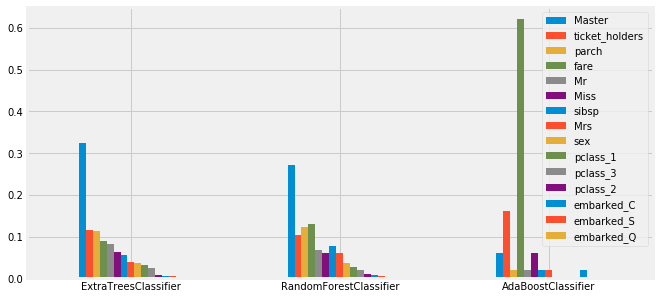

In [231]:
ax = t.plot.bar(figsize=(10,5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

It's interesting that AdaBoost puts so much importance on `fare` (> 60%), where the two Tree algorithms have it at between a half and a third of the most importance feature (~11%). Let's explore the data surrounding `fare` and `age_group`.

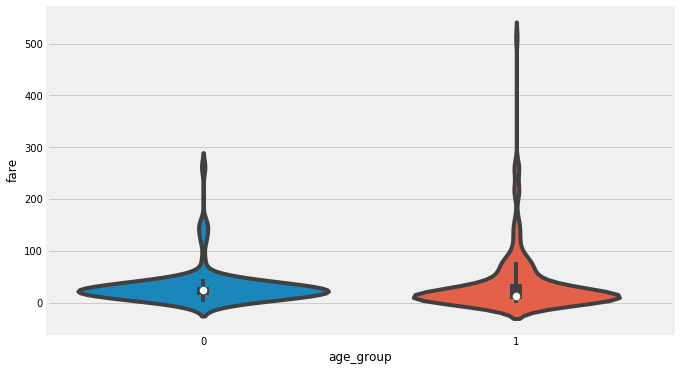

In [240]:
plt.figure(figsize=(10,6))
sns.violinplot(x='age_group', y='fare', data=age_df);

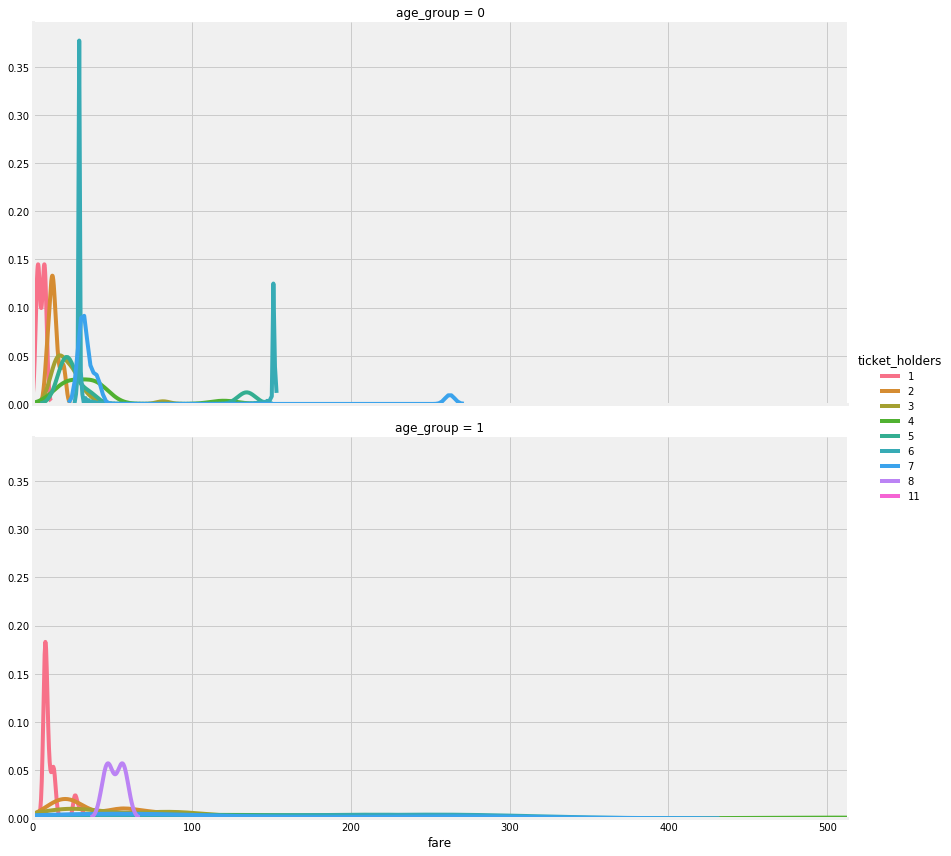

In [277]:
g = sns.FacetGrid(data=age_df, row='age_group', hue='ticket_holders', height=6, aspect=2)
g.map(sns.kdeplot, 'fare').add_legend()
plt.xlim(0, age_df.fare.max());

Looks like `age`, `fare` and `sex` are still the three most important variables. But it is worth noting that `Mr` is right up next to `pclass`, and `Miss` is next to `sibsp`.

Let's see if we can't extra any information out of `cabin`.

In [771]:
train.cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

`cabin` is made up of a letter (the deck) and a number (the room). Let's strip off the letter and make a variable out of it, `deck`.

In [772]:
deck = train.cabin.dropna().str.replace('[\d]', '').str.replace(' ', '')

In [773]:
test_deck = test.cabin.dropna().str.replace('[\d]', '').str.replace(' ', '')

In [774]:
deck.apply(set).str.len().value_counts()

1    200
2      4
Name: cabin, dtype: int64

It appears that there are 4 passengers with cabins on 2 decks. The rest have cabins on 1 deck.

Let's keep the lowest cabin letter (i.e. closer to A) for our `deck` variable. But we will also create another feature called `multi_deck` that will have `1` if the passenger had cabins on multiple decks, else `0`.

In [775]:
multi_deck = (deck.apply(set).str.len() > 1).astype(int)

In [776]:
test_multi_deck = (test_deck.apply(set).str.len() > 1).astype(int)

In [777]:
train['multi_deck'] = multi_deck

In [778]:
test['multi_deck'] = test_multi_deck

In [779]:
min_deck = deck.apply(set).apply(min)

In [780]:
test_min_deck = test_deck.apply(set).apply(min)

In [781]:
train['deck'] = min_deck

In [782]:
test['deck'] = test_min_deck

Since `deck` is categorical, let's encode it to something numeric.

In [783]:
train['deck'] = train.deck.dropna().astype('category').cat.codes

In [784]:
test['deck'] = test.deck.dropna().astype('category').cat.codes

It might also be worth adding unique cabin counts to our dataframe. Let's do that and call the feature `cabin_count`.

In [785]:
train['cabin_count'] = train.cabin.dropna().str.split().apply(set).str.len()

In [786]:
test['cabin_count'] = test.cabin.dropna().str.split().apply(set).str.len()

Now let's check if any of these new columns have any importance regarding survival.

In [787]:
X = train.dropna().select_dtypes(exclude=['O']).drop(columns='survived')
y = train.dropna().select_dtypes(exclude=['O']).survived

In [788]:
model = ExtraTreesClassifier()

In [789]:
fit = model.fit(X, y)

In [790]:
importances = fit.feature_importances_

In [791]:
indices = np.argsort(importances)[::-1]

In [792]:
std = np.std([tree.feature_importances_ for tree in fit.estimators_], axis = 0)

In [793]:
for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]} has importance {importances[indices[f]]}")

age has importance 0.21391859359545945
Mr has importance 0.17568242342387702
fare has importance 0.17038639760728858
sex has importance 0.1136565083536232
deck has importance 0.09859363796087954
sibsp has importance 0.03890977083427722
embarked has importance 0.03421322746780468
parch has importance 0.033135235719567106
Mrs has importance 0.025398924046401428
Miss has importance 0.02518886902716828
cabin_count has importance 0.022166186432093424
pclass has importance 0.014005735205980413
Capt has importance 0.008837104675706125
Dr has importance 0.0061607199740485
Master has importance 0.005545943774817868
multi_deck has importance 0.005226478907080004
Major has importance 0.0038416532557104476
Col has importance 0.0018216462629042016
Sir has importance 0.0016437394084452873
Lady has importance 0.0008338493735408788
Mlle has importance 0.0008085336017881279
Mme has importance 2.4821091538220016e-05
Jonkheer has importance 0.0
Don has importance 0.0
Ms has importance 0.0
Rev has importa

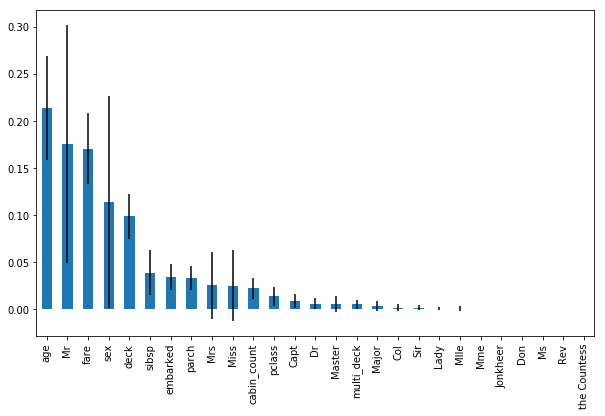

In [794]:
pd.DataFrame(data = importances[indices], index=X.columns[indices]).plot.bar(figsize = (10,6), **{
    'yerr' : std[indices],
    'legend' : False
});

Interesting! `multi_deck` showed very little importance, but `cabin_count` showed as much importance `pclass`, `Master`, and `embarked`. As for `deck`, this shows almost as much importance as `sex`. I think we should try to impute the missing values of `deck`.

Let's find out which of our variables correlate and/or cluster with `deck`.

In [795]:
from sklearn import preprocessing

In [796]:
X = train.dropna().select_dtypes(exclude = ['O']).drop(columns='deck')
y = train.dropna().select_dtypes(exclude = ['O']).deck

In [797]:
scaler = preprocessing.StandardScaler().fit(X)

In [798]:
test_X = test.dropna().select_dtypes(exclude = ['O']).drop(columns='deck')
test_y = test.dropna().select_dtypes(exclude = ['O']).deck

In [799]:
X.corrwith(y).abs().sort_values()

survived        0.016551
parch           0.020822
Dr              0.032273
sibsp           0.032763
Mr              0.047096
Mlle            0.060223
Major           0.060223
Miss            0.061932
the Countess    0.066418
Capt            0.066418
Mme             0.066418
sex             0.076574
Mrs             0.080981
Master          0.097160
Lady            0.114295
Sir             0.114295
Col             0.114295
cabin_count     0.119935
age             0.193906
multi_deck      0.227934
embarked        0.277817
fare            0.297496
pclass          0.589587
Don                  NaN
Jonkheer             NaN
Ms                   NaN
Rev                  NaN
dtype: float64

`pclass` correlates the most with `deck`. `fare`, `embarked`, and `multi_deck` also have correlation with `deck`. Let's check feature importances.

In [800]:
model = ExtraTreesClassifier()

In [801]:
fit = model.fit(scaler.transform(X), y)

In [802]:
importances = fit.feature_importances_

In [803]:
indices = np.argsort(importances)[::-1]

In [804]:
std = np.std([tree.feature_importances_ for tree in fit.estimators_], axis = 0)

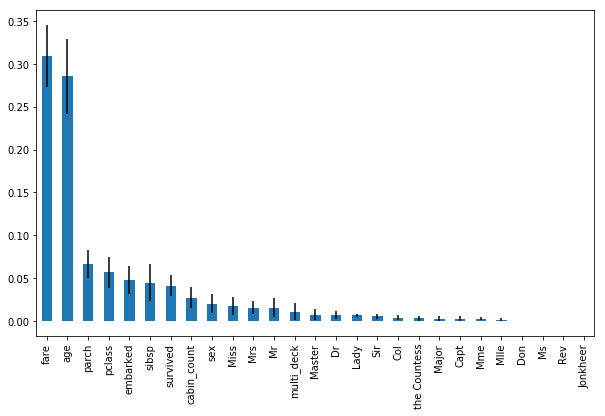

In [805]:
pd.DataFrame(data = importances[indices], index=X.columns[indices]).plot.bar(figsize = (10,6), **{
    'yerr' : std[indices],
    'legend' : False
});

The two most important features are `fare` and `age`. `pclass`, `sibsp`, `parch`, and `embarked` seem like good secondary variables. I want to avoid using `survived` since I won't be able to use it on my test data.

Let's try a few algorithms to see if we can get high accuracy for predicting a passenger's `deck`.

##### Logistic Regression

In [806]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

kfold = model_selection.KFold(n_splits=10)

scaler = preprocessing.StandardScaler().fit(X.loc[:, [
    'fare',
    'age',
    'pclass',
    'sibsp',
    'parch',
    'embarked'
]].copy())

scaled_X = scaler.transform(X.loc[:, [
    'fare',
    'age',
    'pclass',
    'sibsp',
    'parch',
    'embarked'
]])

results = model_selection.cross_val_score(model, scaled_X, y, cv = kfold)

print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.30309523809523814 (0.10222607332783162)


##### Random Forest

In [807]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

kfold = model_selection.KFold(n_splits=10)

results = model_selection.cross_val_score(model, scaled_X, y, cv = kfold)

print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.46047619047619043 (0.06657476658979182)


##### Decision Tree

In [808]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

kfold = model_selection.KFold(n_splits=10)

results = model_selection.cross_val_score(model, scaled_X, y, cv = kfold)

print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.5678571428571428 (0.07594640967720029)


##### Nearest Neighbors

In [809]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

kfold = model_selection.KFold(n_splits=10)

results = model_selection.cross_val_score(model, scaled_X, y, cv = kfold)

print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.3083333333333333 (0.08024374715151393)


##### Gaussian Naive Bayes

In [810]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

kfold = model_selection.KFold(n_splits=10)

results = model_selection.cross_val_score(model, scaled_X, y, cv = kfold)

print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.30166666666666664 (0.14346715000045027)


##### Gaussian Process

In [811]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

model = GaussianProcessClassifier(1 * RBF())

kfold = model_selection.KFold(n_splits=10)

results = model_selection.cross_val_score(model, scaled_X, y, cv = kfold)

print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.28785714285714287 (0.10803045048176238)


##### Ada Boost

In [812]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

kfold = model_selection.KFold(n_splits=10)

results = model_selection.cross_val_score(model, scaled_X, y, cv = kfold)

print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.3223809523809524 (0.09107695283587655)


After comparing Logistic Regression, Random Forest, Decision Tree, Nearest Neighbors, Gaussian Naive Bayes, Gaussian Process, and Ada Boost... I will settle on Random Forest because although it doesn't have the highest accuracy, it does have the second. And it's standard deviation is one of the lowest.

In [813]:
model = RandomForestClassifier()

In [814]:
fit = model.fit(scaled_X, y)

In [815]:
scaled_test_X = scaler.transform(test_X.loc[:, [
    'fare',
    'age',
    'pclass',
    'sibsp',
    'parch',
    'embarked'
]])

test_fit = model.fit(scaled_test_X, test_y)

In [816]:
deck_X = train.loc[train.deck.isnull() == True, [
    'fare',
    'age',
    'pclass',
    'sibsp',
    'parch',
    'embarked'
]].copy()

# scaled_deck_X = 

In [817]:
test_deck_X = test.loc[test.deck.isnull() == True, [
    'fare',
    'age',
    'pclass',
    'sibsp',
    'parch',
    'embarked'
]].copy()

In [818]:
deck_y = fit.predict(deck_X)

In [158]:
test_deck_y = test_fit.predict(test_deck_X)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [161]:
test_deck_X.isnull().sum()

fare        1
age         0
pclass      0
sibsp       0
parch       0
embarked    0
dtype: int64

Before imputing the `deck` values, I want to imput the one missing value in `fare` in my `test` data.

Let's see if we can predict `fare` using our training data.

We should note that not every column in `train` is in `test`. So we should also limit to the columns that can be used in `test`.

In [376]:
fare_y = train.fare
fare_X = train.loc[:, test.columns[test.columns.isin(train.columns)]].dropna(axis = 1).select_dtypes(exclude=['O']).drop(columns='fare')

`fare` is continous, so we should look at using a regression algorithm. Let's test a few and see which one gives the best results.

##### Linear Regression

In [377]:
from sklearn.linear_model import LinearRegression

In [378]:
model = LinearRegression()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X, fare_y, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3573082996213155, (0.14868613034882897)


##### Ridge

In [379]:
from sklearn.linear_model import Ridge

In [380]:
model = Ridge()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X, fare_y, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3580575539762699, (0.14724046508469354)


##### Lasso

In [381]:
from sklearn.linear_model import Lasso

In [382]:
model = Lasso()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X, fare_y, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3648946859393965, (0.1280855863789175)


##### Bayesian Ridge

In [383]:
from sklearn.linear_model import BayesianRidge

In [384]:
model = BayesianRidge()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X, fare_y, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3603277746545629, (0.14090034171211707)


##### Automatic Relevance Determination

In [385]:
from sklearn.linear_model import ARDRegression

In [386]:
model = ARDRegression()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X, fare_y, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3581210828399216, (0.13987423617521638)


Of the algorithms we tried, they all produced roughly the same output (accuracy around 35%-36%). Let's use the Lasso algorithm.

In [387]:
model = Lasso()

In [402]:
fit = model.fit(fare_X, fare_y)

In [403]:
test_fare_X = test.loc[test.fare.isnull(), fare_X.columns]

In [404]:
test_fare_y = model.predict(test_fare_X)

In [405]:
test_fare_y

array([-2.91282786])

What the?! Even though our Lasso algorithm had ~36% accuracy, the value it predicted for our missing `fare` was negative which isn't possible. We should find a new way to predict the `fare`.

Maybe we should try clustering our data, figure out which cluster this passenger belongs in, and then use that cluster to predict the missing `fare`?

Since we don't know how many clusters there might be, let's try an algorithm that doesn't require that as a paramter.

##### Mean Shift

In [410]:
from sklearn.cluster import MeanShift

In [411]:
model = MeanShift()

In [412]:
fit = model.fit(fare_X)

In [422]:
clusters = fit.labels_

In [423]:
len(np.unique(clusters))

2

We are given 2 clusters using Mean Shift. Let's see which cluster our missing `fare` passenger belongs in.

In [424]:
test_fare_cluster = fit.predict(test_fare_X)

In [425]:
test_fare_cluster

array([0], dtype=int64)

Mean Shift puts our passenger in cluster 0. Let's limit our `train` data to that cluster to see if we can get better accuracy when prediciting `fare`.

In [428]:
fare_X['cluster'] = clusters

In [459]:
fare_X0 = fare_X.loc[fare_X.cluster == 0].drop(columns='cluster').copy()

In [460]:
fare_y0 = fare_y.loc[fare_X0.index].copy()

We've limited our `train` data, let's test our regression algorithms against each other again to see if Lasso still comes out on top.

##### Linear Regression

In [461]:
from sklearn.linear_model import LinearRegression

In [462]:
model = LinearRegression()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X0, fare_y0, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.35281775767745743, (0.18523694183775077)


##### Ridge

In [463]:
from sklearn.linear_model import Ridge

In [464]:
model = Ridge()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X0, fare_y0, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3538494589381985, (0.18355899395678896)


##### Lasso

In [465]:
from sklearn.linear_model import Lasso

In [466]:
model = Lasso()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X0, fare_y0, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.36291164531037123, (0.15759204485371156)


##### Bayesian Ridge

In [467]:
from sklearn.linear_model import BayesianRidge

In [468]:
model = BayesianRidge()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X0, fare_y0, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3564457947715208, (0.17610247949511187)


##### Automatic Relevance Determination

In [469]:
from sklearn.linear_model import ARDRegression

In [470]:
model = ARDRegression()
kfold = model_selection.KFold(n_splits=10)
results = model_selection.cross_val_score(model, fare_X0, fare_y0, cv=kfold)
print(f"Accuracy: {results.mean()}, ({results.std()})")

Accuracy: 0.3504867776066801, (0.1755647417893304)


Lasso is still on top and the accuracy didn't get any better... Let's see if we still get the same negative prediction.

In [471]:
model = Lasso()

In [472]:
fit = model.fit(fare_X0, fare_y0)

In [473]:
test_fare_X = test.loc[test.fare.isnull(), fare_X0.columns]

In [474]:
test_fare_y = model.predict(test_fare_X)

In [476]:
test_fare_y

array([-7.62368766])

Our predicted value is even more negative...

Let's try a different clustering algorithm and see if that gives any better clusters.

##### Hiearchy

In [503]:
from scipy.cluster import hierarchy

In [520]:
linkage = hierarchy.linkage(fare_X, method = 'ward')

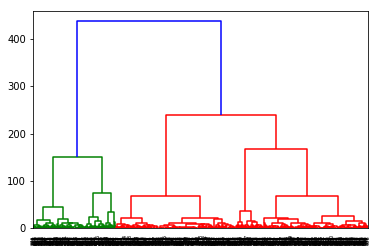

In [521]:
fit = hierarchy.dendrogram(linkage, )

Looking at this dendrogram it appears there might be more than 2 clusters. In fact, we could say there are 2 to 5 clusters. Let's try to confirm this using the elbow method and the K-Means algorithm.

In [523]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [ ]:
distortions = []
K = range(1,11)
for k in K:
    model = KMeans(n_clusters=k)
    fit = model.fit(fare_X)
    distortions.append(sum(np.min(cd)))

In [426]:
train.deck.value_counts(normalize=True)

2.0    0.289216
1.0    0.230392
3.0    0.161765
4.0    0.161765
0.0    0.073529
5.0    0.058824
6.0    0.019608
7.0    0.004902
Name: deck, dtype: float64

In [156]:
train.loc[train.deck.isnull(), 'deck'] = deck_y

In [157]:
test.loc[test.deck.isnull(), 'deck'] = test_deck_y

ValueError: Must have equal len keys and value when setting with an iterable

In [437]:
train.deck.value_counts(normalize=True)

5.0    0.386083
4.0    0.225589
3.0    0.163861
2.0    0.092031
1.0    0.060606
6.0    0.046016
0.0    0.024691
7.0    0.001122
Name: deck, dtype: float64

I have now imputed missing values in the columns I consider important for predicting survival. Let's check and see if the same features are still important.

In [438]:
model = ExtraTreesClassifier()

In [450]:
X = train.loc[:, train.columns[train.notnull().all()]].select_dtypes(exclude=['O']).drop(columns='survived')
y = train.loc[:, train.columns[train.notnull().all()]].select_dtypes(exclude=['O']).survived

In [451]:
fit = model.fit(X, y)

In [452]:
importances = fit.feature_importances_

In [453]:
indices = np.argsort(importances)[::-1]

In [454]:
std = np.std([tree.feature_importances_ for tree in fit.estimators_], axis = 0)

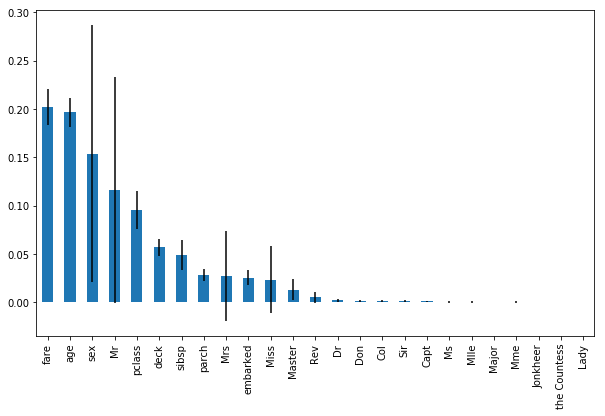

In [455]:
pd.DataFrame(data = importances[indices], index=X.columns[indices]).plot.bar(figsize = (10,6), **{
    'yerr' : std[indices],
    'legend' : False
});

`fare`, `age`, and `sex` are still the top 3. Let's run our algorithm using all the features above and see what our accuracy looks like.

##### Logistic Regression

In [462]:
from sklearn.linear_model import LogisticRegression

In [463]:
model = LogisticRegression()

In [464]:
kfold = model_selection.KFold(n_splits=10)

In [465]:
results = model_selection.cross_val_score(model, X, y, cv = kfold)

In [466]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.8249188514357053 (0.04147973469822705)


##### Random Forest

In [467]:
from sklearn.ensemble import RandomForestClassifier

In [468]:
model = RandomForestClassifier()

In [469]:
kfold = model_selection.KFold(n_splits=10)

In [470]:
results = model_selection.cross_val_score(model, X, y, cv = kfold)

In [471]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.7991635455680399 (0.03377373921124881)


##### Decision Tree

In [472]:
from sklearn.tree import DecisionTreeClassifier

In [473]:
model = DecisionTreeClassifier()

In [474]:
kfold = model_selection.KFold(n_splits=10)

In [475]:
results = model_selection.cross_val_score(model, X, y, cv = kfold)

In [476]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.7801123595505618 (0.04204724980014256)


##### Nearest Neighbors

In [477]:
from sklearn.neighbors import KNeighborsClassifier

In [478]:
model = KNeighborsClassifier()

In [479]:
kfold = model_selection.KFold(n_splits=10)

In [480]:
results = model_selection.cross_val_score(model, X, y, cv = kfold)

In [481]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.7160799001248439 (0.03107856051216875)


##### Gaussian Naive Bayes

In [482]:
from sklearn.naive_bayes import GaussianNB

In [483]:
model = GaussianNB()

In [484]:
kfold = model_selection.KFold(n_splits=10)

In [485]:
results = model_selection.cross_val_score(model, X, y, cv = kfold)

In [486]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.743096129837703 (0.05204354011548779)


##### Gaussian Process

In [487]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [488]:
model = GaussianProcessClassifier(1 * RBF())

In [489]:
kfold = model_selection.KFold(n_splits=10)

In [490]:
results = model_selection.cross_val_score(model, X, y, cv = kfold)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpc.py:430: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.03812085, -0.02685385]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [491]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.38378277153558055 (0.070492433522623)


##### Ada Boost

In [492]:
from sklearn.ensemble import AdaBoostClassifier

In [493]:
model = AdaBoostClassifier()

In [494]:
kfold = model_selection.KFold(n_splits=10)

In [495]:
results = model_selection.cross_val_score(model, X, y, cv = kfold)

In [496]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.8227340823970037 (0.031625238406154284)


Logistic Regression and Ada Boost both performed the best when using all of the variables. Let's limit the features and run them again to see if we improve our accuracy.

##### Logistic Regression

In [499]:
from sklearn.linear_model import LogisticRegression

In [500]:
model = LogisticRegression()

In [501]:
kfold = model_selection.KFold(n_splits=10)

In [502]:
results = model_selection.cross_val_score(model, X.loc[:, :'Master'], y, cv = kfold)

In [503]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.8249063670411985 (0.034926474252515834)


##### Random Forest

In [504]:
from sklearn.ensemble import RandomForestClassifier

In [505]:
model = RandomForestClassifier()

In [506]:
kfold = model_selection.KFold(n_splits=10)

In [507]:
results = model_selection.cross_val_score(model, X.loc[:, :'Master'], y, cv = kfold)

In [508]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.799151061173533 (0.038094582809184284)


##### Decision Tree

In [509]:
from sklearn.tree import DecisionTreeClassifier

In [510]:
model = DecisionTreeClassifier()

In [511]:
kfold = model_selection.KFold(n_splits=10)

In [512]:
results = model_selection.cross_val_score(model, X.loc[:, :'Master'], y, cv = kfold)

In [513]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.7755680399500624 (0.0231704476280234)


##### Nearest Neighbors

In [514]:
from sklearn.neighbors import KNeighborsClassifier

In [515]:
model = KNeighborsClassifier()

In [516]:
kfold = model_selection.KFold(n_splits=10)

In [517]:
results = model_selection.cross_val_score(model, X.loc[:, :'Master'], y, cv = kfold)

In [518]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.7071161048689139 (0.03699343288349287)


##### Gaussian Naive Bayes

In [519]:
from sklearn.naive_bayes import GaussianNB

In [520]:
model = GaussianNB()

In [521]:
kfold = model_selection.KFold(n_splits=10)

In [522]:
results = model_selection.cross_val_score(model, X.loc[:, :'Master'], y, cv = kfold)

In [523]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.4835455680399501 (0.150161690967872)


##### Gaussian Process

In [524]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [525]:
model = GaussianProcessClassifier(1 * RBF())

In [526]:
kfold = model_selection.KFold(n_splits=10)

In [527]:
results = model_selection.cross_val_score(model, X.loc[:, :'Master'], y, cv = kfold)

C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpc.py:430: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.72809561,  0.25005797]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\IT045886\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpc.py:430: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.59678357e+00, -1.51224160e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [528]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.5080649188514357 (0.2133504285537796)


##### Ada Boost

In [529]:
from sklearn.ensemble import AdaBoostClassifier

In [530]:
model = AdaBoostClassifier()

In [531]:
kfold = model_selection.KFold(n_splits=10)

In [532]:
results = model_selection.cross_val_score(model, X.loc[:, :'Master'], y, cv = kfold)

In [533]:
print(f"Accuracy: {results.mean()} ({results.std()})")

Accuracy: 0.811498127340824 (0.03547591560917852)


Some of the algorithms (albeit few) perform better with fewer variables. But the ones that performed the best previously either showed little to no change, or were negatively impacted.

Let's submit results using all of the variables in `X`.

To do this we will need to clean our `test` data like we did our `train` data.

# Test

In [536]:
test.isnull().any()

pclass      False
name        False
sex         False
age          True
sibsp       False
parch       False
ticket      False
fare         True
cabin        True
embarked    False
dtype: bool

Have to impute `age` and create our `deck` variable. We must also find a way to impute `fare` as there is a missing value in our `test` data, but not in our `train` data.